#  BLOQUE 1 — Descarga de una carpeta específica desde GitHub en Google Colab (Sparse Checkout)



## 1. Propósito del bloque
Este bloque implementa un procedimiento **reproducible y eficiente** para descargar **solo una carpeta específica** (`DataImg`) desde un repositorio GitHub, evitando clonar todo el proyecto.  
El resultado final deja dicha carpeta disponible en **Google Colab** en la ruta:

- **`/content/DataImg`**

Esto es especialmente útil en proyectos de **Machine Learning con datasets grandes**, donde clonar todo el repositorio puede ser lento, innecesario y consumir espacio.

---

## 2. Librerías utilizadas y su rol
En este bloque se importan librerías estándar de Python para administración del sistema:

- **`os`**: manejo de rutas y verificación de existencia de archivos/carpetas.
- **`shutil`**: operaciones de alto nivel con archivos (borrar carpetas, mover directorios).
- **`subprocess`**: ejecución de comandos de sistema (en este caso, comandos `git`) desde Python.

---

## 3. Definición de parámetros clave
Se establecen variables que controlan el flujo de descarga:

- **URL del repositorio**: fuente de datos (GitHub).
- **Nombre de la carpeta objetivo**: `DataImg`, que es lo único que se desea descargar.
- **Directorio temporal**: carpeta intermedia donde se inicializa Git antes de mover el resultado a `/content`.

Esta separación permite:
- trabajar “en limpio”,
- y luego copiar solo lo necesario al directorio principal de Colab.

---

## 4. Funciones auxiliares (helpers)
El bloque define dos funciones para mejorar robustez y legibilidad:

### 4.1. Ejecutor de comandos (`run`)
Se crea una función que:
- imprime el comando a ejecutar (para trazabilidad),
- y lo ejecuta usando `subprocess`.

Esto aporta **transparencia**, porque se puede auditar qué comandos se ejecutaron y en qué orden.

### 4.2. Detección automática de la rama por defecto
Se implementa una función que consulta el repositorio remoto para determinar si su rama principal es:

- `main` o
- `master`

Esto evita errores típicos al asumir incorrectamente el nombre de la rama.  
Si por algún motivo no se logra detectar, se usa `main` como valor por defecto.

---

## 5. Preparación del entorno (limpieza)
Antes de descargar, el bloque elimina:

- cualquier repositorio temporal previo,
- cualquier carpeta `/content/DataImg` existente.

Luego crea nuevamente el directorio temporal vacío.

**Justificación técnica:**  
Esto garantiza reproducibilidad y evita inconsistencias por ejecuciones anteriores, lo cual es una buena práctica en Colab (entornos repetibles).

---

## 6. Identificación de la rama remota activa
Se ejecuta el proceso de detección de rama por defecto y se imprime el resultado.

**Importancia:**  
El comando de descarga posterior debe apuntar exactamente a esa rama. De lo contrario, el `pull` fallará o no encontrará la carpeta.

---

## 7. Inicialización de un repositorio temporal y configuración de Sparse Checkout
En el directorio temporal se realiza una configuración Git mínima:

1. **Inicializar Git localmente** (sin clonar todo).
2. **Agregar el remoto** (enlace al repositorio de GitHub).
3. **Activar sparse checkout** (modo “cone”, más simple y eficiente).
4. **Indicar la carpeta objetivo** (`DataImg`) como único contenido a recuperar.

**Concepto clave (Sparse Checkout):**  
Git permite trabajar con **solo una parte** del repositorio, descargando únicamente los archivos requeridos.

---

## 8. Descarga parcial del repositorio (solo la carpeta requerida)
Se realiza un `pull` remoto con dos optimizaciones importantes:

- **`--depth 1`**: descarga solo el último snapshot del repositorio (historial mínimo).
- Descarga únicamente lo configurado por sparse checkout (la carpeta seleccionada).

**Beneficio:**  
Menor tiempo de descarga y menor uso de espacio, ideal para datasets.

---

## 9. Validación de existencia y traslado al directorio final
Tras descargar, el bloque:

1. Construye la ruta de origen dentro del repo temporal.
2. Construye la ruta destino final: `/content/DataImg`.
3. Verifica que la carpeta exista (validación robusta).
   - Si no existe, se lanza un error explícito indicando:
     - que no se encontró la carpeta,
     - y en qué rama se buscó.

Luego se mueve la carpeta descargada a `/content` y se elimina el directorio temporal.

---

## 10. Salida final y verificación rápida
Finalmente, se imprime:

- la ruta final donde quedó la carpeta,
- una lista parcial con los primeros archivos (hasta 30).

**Objetivo:**  
Validación rápida para confirmar que el dataset/carpeta está disponible para los siguientes bloques del pipeline (por ejemplo: carga de imágenes, entrenamiento, etc.).

---

##  Resultado esperado del bloque
Al terminar, el entorno de Colab queda listo para continuar con el proyecto:

- Carpeta disponible en: **`/content/DataImg`**
- Descarga eficiente: **solo lo necesario**, sin clonar todo el repositorio.
- Ejecución repetible: limpia estados previos y valida errores comunes.


In [ ]:
# ============================================
# BLOQUE 1
# Descargar SOLO una carpeta desde GitHub en Google Colab (Sparse Checkout)
# Deja la carpeta lista en /content/DataImg
# ============================================

import os
import shutil
import subprocess

# 1) Variables
REPO_URL = "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"
FOLDER_NAME = "DataImg"
TMP_DIR = "/content/repo_temporal"

# 2) Helpers
def run(cmd, cwd=None):
    print(f"\n$ {cmd}")
    subprocess.check_call(cmd, shell=True, cwd=cwd)

def get_default_branch(repo_url):
    # Detecta rama por defecto (main / master)
    try:
        out = subprocess.check_output(
            f'git ls-remote --symref {repo_url} HEAD',
            shell=True,
            text=True
        )
        for line in out.splitlines():
            if line.startswith("ref:"):
                return line.split("refs/heads/")[-1].split("\t")[0].strip()
    except Exception:
        pass
    return "main"

# 3) Preparación: limpiar previos
shutil.rmtree(TMP_DIR, ignore_errors=True)
shutil.rmtree(f"/content/{FOLDER_NAME}", ignore_errors=True)
os.makedirs(TMP_DIR, exist_ok=True)

# 4) Detectar rama por defecto
BRANCH = get_default_branch(REPO_URL)
print(f" Rama detectada: {BRANCH}")

# 5) Inicializar repo temporal y configurar sparse checkout
run("git init", cwd=TMP_DIR)
run(f'git remote add origin "{REPO_URL}"', cwd=TMP_DIR)
run("git sparse-checkout init --cone", cwd=TMP_DIR)
run(f'git sparse-checkout set "{FOLDER_NAME}"', cwd=TMP_DIR)

# 6) Descargar solo esa carpeta
run(f'git pull --depth 1 origin "{BRANCH}"', cwd=TMP_DIR)

# 7) Mover a /content y limpiar
src_path = os.path.join(TMP_DIR, FOLDER_NAME)
dst_path = os.path.join("/content", FOLDER_NAME)

if not os.path.exists(src_path):
    raise FileNotFoundError(
        f"No se encontró la carpeta '{FOLDER_NAME}' en el repo. "
        f"Revisa que exista en la rama '{BRANCH}'."
    )

shutil.move(src_path, dst_path)
shutil.rmtree(TMP_DIR, ignore_errors=True)

print(f"\n Proceso finalizado. Carpeta lista en: {dst_path}")
print(" Archivos (primeros 30):")
print(os.listdir(dst_path)[:30])


 Rama detectada: main

$ git init

$ git remote add origin "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"

$ git sparse-checkout init --cone

$ git sparse-checkout set "DataImg"

$ git pull --depth 1 origin "main"

 Proceso finalizado. Carpeta lista en: /content/DataImg
 Archivos (primeros 30):
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___healthy', 'Tomato___Target_Spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'plantvillage', 'Tomato___Leaf_Mold', 'Tomato___Late_blight', 'val', 'TomatoDataset_ready', 'Tomato___Tomato_mosaic_virus', 'train']


# BLOQUE 2 — Generación e impresión de un árbol de directorios (solo subcarpetas, sin archivos)



## 1. Propósito del bloque
Este bloque tiene como objetivo **inspeccionar y documentar la estructura del dataset** en Google Colab, imprimiendo un **árbol de directorios** que muestra **exclusivamente las subcarpetas** (clases) y su jerarquía, **sin listar archivos** (imágenes).

En un problema de **clasificación supervisada de imágenes**, esta verificación es clave porque normalmente el dataset se organiza como:

- **Una carpeta raíz** (dataset)
- **Subcarpetas por clase** (p. ej., enfermedades)
- **Imágenes dentro de cada subcarpeta**

Esto permite validar rápidamente si el dataset cumple la estructura esperada por cargadores como `image_dataset_from_directory`.

---

## 2. Importación y dependencia utilizada
Se utiliza únicamente la librería estándar:

- **`os`**: manejo de rutas y recorrido del sistema de archivos.

Esto hace que el bloque sea **portable, autocontenido y reproducible** en Colab.

---

## 3. Definición del directorio raíz del dataset
Se define una variable que apunta a la carpeta donde se espera encontrar el dataset descargado previamente:

- **`ROOT_DIR = "/content/DataImg"`**

 Importancia práctica:
- Esta ruta corresponde a la salida del **BLOQUE 1**, donde se dejó la carpeta descargada desde GitHub.

---

## 4. Validación de existencia (control de errores)
Antes de recorrer el árbol, el bloque verifica si la ruta realmente existe.

- Si la ruta **no existe**, se detiene la ejecución con un error explícito.
- El mensaje sugiere la causa más probable: **no ejecutar el BLOQUE 1**, o que la carpeta se llame distinto.

 Buenas prácticas:
- Evita “errores en cascada” más adelante.
- Entrega un diagnóstico claro y accionable.

---

## 5. Función para imprimir el árbol de directorios
Se define una función cuyo propósito es imprimir un árbol jerárquico de carpetas, con parámetros de control:

### 5.1. Parámetro `max_depth`
- Controla la **profundidad máxima** del árbol.
- Evita que el listado crezca demasiado si el dataset tiene muchas capas de subdirectorios.

 Justificación:
- En datasets grandes, limitar profundidad mejora legibilidad y evita excesiva salida en pantalla.

### 5.2. Normalización de la ruta
Dentro de la función:
- Se convierte la ruta a una forma **absoluta** para evitar ambigüedades.
- Se calcula la “profundidad base” (nivel raíz) para poder medir correctamente el nivel de indentación.

---

## 6. Recorrido del sistema de archivos con `os.walk`
El bloque recorre el árbol usando un recorrido tipo DFS sobre el sistema de archivos:

- **`root`**: directorio actual
- **`dirs`**: lista de subcarpetas
- **`_`**: placeholder para archivos (se ignoran explícitamente)

 Idea central:
- Se **ignoran archivos** deliberadamente, porque el interés aquí es validar la **estructura de clases**, no ver imágenes.

---

## 7. Control de profundidad durante el recorrido
En cada iteración se calcula la profundidad actual:

- Si la profundidad supera `max_depth`:
  - se vacía la lista de subdirectorios a explorar,
  - y se evita seguir bajando.

 Esto implementa una **poda del recorrido**, controlando el tamaño del resultado.

---

## 8. Formato tipo “árbol” e indentación
Para cada carpeta:
- Se calcula una indentación proporcional al nivel de profundidad.
- Se imprime el nombre de la carpeta con un formato visual tipo árbol (`├──`, `│`).

 Beneficio:
- Permite visualizar la jerarquía de forma clara (similar a comandos como `tree` en Linux).

---

## 9. Ordenamiento alfabético de subcarpetas
Antes de imprimir/recorrer, las subcarpetas se ordenan alfabéticamente.

 Ventajas:
- Resultados **deterministas** (siempre la misma salida).
- Facilita comparar ejecuciones y detectar cambios en estructura.

---

## 10. Ejecución final de la función
Finalmente, se llama a la función pasando:

- la carpeta raíz del dataset
- una profundidad máxima definida (10 niveles)

Esto imprime el árbol


In [ ]:
# ============================================
# BLOQUE 2
# Crear un árbol SOLO con subcarpetas (sin archivos)
# ============================================

import os

ROOT_DIR = "/content/DataImg"   # cambia esto si tu carpeta tiene otro nombre

if not os.path.exists(ROOT_DIR):
    raise FileNotFoundError(f"No existe la ruta: {ROOT_DIR}. ¿Ejecutaste el BLOQUE 1?")

def print_dir_tree(path, max_depth=10):
    """
    Imprime un árbol de SOLO directorios.
    - max_depth: profundidad máxima del árbol
    """
    path = os.path.abspath(path)
    base_depth = path.rstrip(os.sep).count(os.sep)

    print(f" Árbol de directorios: {path}\n")

    for root, dirs, _ in os.walk(path):
        depth = root.count(os.sep) - base_depth
        if depth > max_depth:
            dirs[:] = []
            continue

        indent = "│   " * depth
        folder_name = os.path.basename(root) if root != path else os.path.basename(path)
        print(f"{indent}├── {folder_name}/")

        # Orden alfabético
        dirs.sort()

print_dir_tree(ROOT_DIR, max_depth=10)


 Árbol de directorios: /content/DataImg

├── DataImg/
│   ├── TomatoDataset_ready/
│   │   ├── Tomato___Bacterial_spot/
│   │   ├── Tomato___Early_blight/
│   │   ├── Tomato___Late_blight/
│   │   ├── Tomato___Leaf_Mold/
│   │   ├── Tomato___Septoria_leaf_spot/
│   │   ├── Tomato___Spider_mites Two-spotted_spider_mite/
│   │   ├── Tomato___Target_Spot/
│   │   ├── Tomato___Tomato_Yellow_Leaf_Curl_Virus/
│   │   ├── Tomato___Tomato_mosaic_virus/
│   │   ├── Tomato___healthy/
│   ├── Tomato___Bacterial_spot/
│   ├── Tomato___Early_blight/
│   ├── Tomato___Late_blight/
│   ├── Tomato___Leaf_Mold/
│   ├── Tomato___Septoria_leaf_spot/
│   ├── Tomato___Spider_mites Two-spotted_spider_mite/
│   ├── Tomato___Target_Spot/
│   ├── Tomato___Tomato_Yellow_Leaf_Curl_Virus/
│   ├── Tomato___Tomato_mosaic_virus/
│   ├── Tomato___healthy/
│   ├── plantvillage/
│   │   ├── Tomato___Bacterial_spot/
│   │   ├── Tomato___Early_blight/
│   │   ├── Tomato___Late_blight/
│   │   ├── Tomato___Leaf_Mold/
│   │

#  BLOQUE 3 — Búsqueda de subdirectorios que contienen la palabra clave “tomato”



## 1. Propósito del bloque
Este bloque realiza una **búsqueda sistemática dentro del dataset** para identificar todas las **subcarpetas (directorios)** cuyos nombres contienen la palabra clave **“tomato”** (sin distinguir mayúsculas/minúsculas).

En proyectos de **clasificación de imágenes**, este tipo de verificación es útil para:

- Confirmar que el dataset contiene la categoría de interés (p. ej., *Tomato*).
- Detectar variantes de nombres de clases (por ejemplo: `Tomato___healthy`, `tomato_leaf_mold`, etc.).
- Diagnosticar errores de organización del dataset antes de entrenar modelos.

---

## 2. Dependencia utilizada
Se utiliza la librería estándar:

- **`os`**: permite recorrer el sistema de archivos y manipular rutas de forma portable en Colab.

---

## 3. Definición de parámetros clave
Se definen dos variables centrales:

- **`ROOT_DIR`**: ruta de la carpeta raíz del dataset en Colab (por defecto: `/content/DataImg`).
- **`KEYWORD`**: palabra clave de búsqueda (por defecto: `"tomato"`).

 En términos prácticos:
- Si tu dataset incluye múltiples plantas (maíz, papa, etc.), esta búsqueda permite **filtrar rápidamente** solo lo relacionado con tomate.

---

## 4. Validación temprana del entorno
Antes de iniciar la búsqueda, el bloque verifica si la ruta raíz existe.

- Si **no existe**, se detiene con un error explícito indicando la posible causa: no ejecutar el BLOQUE 1 o ruta incorrecta.

 Esta validación evita errores posteriores y facilita depuración.

---

## 5. Estructura de almacenamiento de resultados
Se inicializa una lista vacía para almacenar los directorios que cumplan la condición.

 Justificación:
- Permite recolectar resultados durante el recorrido.
- Facilita luego imprimirlos y contar cuántos fueron encontrados.

---

## 6. Recorrido del dataset mediante exploración jerárquica
El bloque recorre recursivamente toda la estructura de carpetas desde `ROOT_DIR` utilizando un recorrido basado en `os.walk`.

En cada nivel, se obtiene:

- la ruta actual del recorrido,
- la lista de subcarpetas,
- y los archivos (que aquí no se utilizan).

 La búsqueda se aplica **solo sobre nombres de subcarpetas**, porque el objetivo es encontrar **clases o categorías**, no imágenes individuales.

---

## 7. Condición de filtrado (búsqueda por substring)
Para cada subcarpeta encontrada:

- Se normaliza el texto a minúsculas.
- Se verifica si la palabra clave “tomato” aparece como **subcadena** del nombre.

 Ventajas de este enfoque:
- No depende de coincidencia exacta.
- Detecta múltiples variantes (ej.: `Tomato___Late_blight`, `tomatoHealthy`, etc.).
- Es robusto frente a diferencias de mayúsculas/minúsculas.

---

## 8. Construcción de ruta completa y registro
Cuando un directorio cumple la condición:

- Se construye su **ruta completa** combinando la ruta actual y el nombre de la carpeta.
- Se agrega esa ruta a la lista de resultados.

 Importancia práctica:
- Guardar rutas completas facilita su uso posterior, por ejemplo:
  - para restringir entrenamiento a un subconjunto,
  - o para verificar manualmente contenidos.

---

## 9. Presentación de resultados
Finalmente el bloque:

1. Imprime un encabezado descriptivo.
2. Lista cada ruta encontrada (una por línea).
3. Muestra el total de coincidencias.

 Esto permite validar rápidamente:
- si el dataset contiene clases asociadas a tomate,
- cuántas variantes existen,
- y dónde están ubicadas.

---

##  Resultado esperado del bloque
Al ejecutar este bloque se obtiene:

- Una lista de directorios del dataset cuyos nombres incluyen “tomato”.
- Un conteo total de coincidencias.

Esto funciona como una **inspección previa** antes de:
- cargar el dataset con Keras,
- definir el conjunto de clases,
- y entrenar un modelo de clasificación de enfermedades foliares en tomate.


In [ ]:
# ============================================
# BLOQUE 3
# Buscar directorios que contengan la palabra "tomato"
# ============================================

import os

ROOT_DIR = "/content/DataImg"   # carpeta raíz del dataset
KEYWORD = "tomato"

if not os.path.exists(ROOT_DIR):
    raise FileNotFoundError(f"No existe la ruta: {ROOT_DIR}. ¿Ejecutaste el BLOQUE 1?")

tomato_dirs = []

for root, dirs, _ in os.walk(ROOT_DIR):
    for d in dirs:
        if KEYWORD.lower() in d.lower():
            full_path = os.path.join(root, d)
            tomato_dirs.append(full_path)

# Mostrar resultados
print(" Directorios que contienen 'tomato':\n")
for d in tomato_dirs:
    print(" -", d)

print(f"\n Total de directorios encontrados: {len(tomato_dirs)}")


 Directorios que contienen 'tomato':

 - /content/DataImg/Tomato___Bacterial_spot
 - /content/DataImg/Tomato___Early_blight
 - /content/DataImg/Tomato___Septoria_leaf_spot
 - /content/DataImg/Tomato___healthy
 - /content/DataImg/Tomato___Target_Spot
 - /content/DataImg/Tomato___Spider_mites Two-spotted_spider_mite
 - /content/DataImg/Tomato___Tomato_Yellow_Leaf_Curl_Virus
 - /content/DataImg/Tomato___Leaf_Mold
 - /content/DataImg/Tomato___Late_blight
 - /content/DataImg/TomatoDataset_ready
 - /content/DataImg/Tomato___Tomato_mosaic_virus
 - /content/DataImg/plantvillage/Tomato___Bacterial_spot
 - /content/DataImg/plantvillage/Tomato___Early_blight
 - /content/DataImg/plantvillage/Tomato___Septoria_leaf_spot
 - /content/DataImg/plantvillage/Tomato___healthy
 - /content/DataImg/plantvillage/Tomato___Target_Spot
 - /content/DataImg/plantvillage/Tomato___Spider_mites Two-spotted_spider_mite
 - /content/DataImg/plantvillage/Tomato___Tomato_Yellow_Leaf_Curl_Virus
 - /content/DataImg/plantvil

#  BLOQUE 4 — Construcción de un nuevo dataset de *tomato* copiando subdirectorios y evitando conflictos de nombres



## 1. Propósito del bloque
Este bloque crea un **dataset derivado** que contiene **solo las clases relacionadas con “tomato”**, copiando las carpetas detectadas previamente (en el BLOQUE 3) hacia un nuevo directorio:

- **`/content/TomatoDataset`**

El objetivo práctico es **aislar un subconjunto del dataset original**, dejando un dataset más “limpio” y específico para entrenar un modelo de clasificación de enfermedades en tomate.

---

## 2. Dependencias utilizadas
Se emplean librerías estándar para manipulación de archivos:

- **`os`**: manejo de rutas y nombres de carpetas.
- **`shutil`**: operaciones de copia y eliminación de directorios completos.

Estas librerías permiten realizar **ETL a nivel de sistema de archivos**, una etapa frecuente en proyectos de visión por computador.

---

## 3. Definición del directorio destino (nuevo dataset)
Se define `NEW_ROOT_DIR` como la carpeta que contendrá el nuevo dataset de tomate.

 En términos de *pipeline*:
- **Dataset original**: contiene múltiples especies/clases.
- **Dataset derivado**: contendrá únicamente clases relevantes para tomate, facilitando entrenamiento, validación y despliegue.

---

## 4. Verificación de prerrequisito: existencia de `tomato_dirs`
El bloque valida que exista en memoria la variable `tomato_dirs`, que corresponde a la lista de directorios encontrados en el BLOQUE 3.

- Si no existe, se detiene con un error explícito indicando qué bloque ejecutar antes.

 Esto asegura consistencia del flujo y evita errores por ejecución fuera de orden.

---

## 5. Creación de una carpeta destino “limpia”
Antes de copiar, el bloque:

1. Elimina la carpeta destino si ya existe (borrado recursivo).
2. Crea nuevamente la carpeta destino vacía.

**Justificación técnica:**
- Garantiza reproducibilidad: cada ejecución genera el mismo dataset desde cero.
- Evita mezclar resultados antiguos con nuevos (problema común en Colab).

---

## 6. Estrategia para evitar conflictos: generación de nombres únicos
Se define una función auxiliar que asegura que **no ocurran colisiones de nombres** al copiar carpetas al nuevo dataset.

### 6.1. Problema que resuelve
En un dataset grande, pueden existir **subdirectorios con el mismo nombre** en rutas distintas.  
Si se copian todos al mismo destino, se produciría un conflicto (ya existe una carpeta con ese nombre).

### 6.2. Solución implementada
- Se propone un nombre candidato igual al original.
- Si el nombre ya existe en el destino, se genera una variante con sufijo, por ejemplo:
  - `Tomato___healthy__dup1`
  - `Tomato___healthy__dup2`
- Se repite hasta encontrar un nombre disponible.

 Ventaja: el proceso es robusto y no se detiene ante duplicados.

---

## 7. Contadores de control y trazabilidad
Se inicializan dos contadores:

- **`copied`**: cuántos directorios se copiaron efectivamente.
- **`renamed`**: cuántos requirieron renombrado por duplicado.

 Esto permite auditoría posterior:
- saber el tamaño del dataset creado,
- detectar cuántas colisiones hubo,
- y evaluar si conviene normalizar nombres desde la fuente.

---

## 8. Copia de cada directorio “tomato” al nuevo dataset
El bloque recorre cada ruta en `tomato_dirs` y realiza:

1. **Extracción del nombre de la carpeta fuente** (clase).
2. **Cálculo del nombre final único** en el destino.
3. Incremento del contador `renamed` si hubo cambio de nombre.
4. Construcción de la ruta destino.
5. Impresión de trazabilidad:
   - origen ➜ destino
6. Copia completa del árbol de la carpeta usando copia recursiva.
7. Incremento del contador `copied`.

**Concepto importante:**
- Copiar directorios completos preserva la estructura interna (imágenes), esencial para que el dataset sea compatible con cargadores basados en carpetas/clases.

---

## 9. Reporte final del proceso
Al finalizar, el bloque imprime:

- cantidad total de directorios copiados,
- cantidad de directorios renombrados por duplicados,
- ruta final del dataset,
- listado del contenido raíz del nuevo dataset.

 Esta salida cumple una función de **validación rápida**:
- confirma que el dataset fue generado,
- que contiene las clases esperadas,
- y que está listo para ser consumido por un pipeline de entrenamiento.

---

##  Resultado esperado del bloque
Tras ejecutar este bloque, queda disponible:

- Un **dataset filtrado** en: **`/content/TomatoDataset`**
- Con subcarpetas que representan clases relacionadas con tomate.
- Sin conflictos por nombres duplicados.
- Listo para entrenamiento con herramientas como:
  - `tf.keras.utils.image_dataset_from_directory`
  - `ImageDataGenerator`
  - pipelines con `tf.data`

Este bloque corresponde a una etapa de **curación y construcción de dataset**, fundamental para asegurar un flujo de entrenamiento robusto y reproducible.


In [ ]:
# ============================================
# BLOQUE 4
# Copiar directorios "tomato" a un nuevo dataset
# evitando conflictos de nombres
# ============================================

import os
import shutil

NEW_ROOT_DIR = "/content/TomatoDataset"

# Verificación
if "tomato_dirs" not in globals():
    raise NameError("No existe 'tomato_dirs'. Ejecuta primero el BLOQUE 3.")

# Crear carpeta limpia
shutil.rmtree(NEW_ROOT_DIR, ignore_errors=True)
os.makedirs(NEW_ROOT_DIR, exist_ok=True)

def get_unique_name(base_dir, folder_name):
    """Genera nombres únicos si ya existe la carpeta"""
    candidate = folder_name
    counter = 1
    while os.path.exists(os.path.join(base_dir, candidate)):
        candidate = f"{folder_name}__dup{counter}"
        counter += 1
    return candidate

copied = 0
renamed = 0

for src_dir in tomato_dirs:
    base_name = os.path.basename(src_dir)
    final_name = get_unique_name(NEW_ROOT_DIR, base_name)

    if final_name != base_name:
        renamed += 1

    dst_dir = os.path.join(NEW_ROOT_DIR, final_name)

    print(f" Copiando: {src_dir}")
    print(f"    ➜  {dst_dir}")

    shutil.copytree(src_dir, dst_dir)
    copied += 1

print("\n Proceso finalizado")
print(f" Directorios copiados: {copied}")
print(f"  Directorios renombrados por duplicado: {renamed}")
print(f" Dataset final en: {NEW_ROOT_DIR}")
print("\nContenido raíz:")
print(os.listdir(NEW_ROOT_DIR))


 Copiando: /content/DataImg/Tomato___Bacterial_spot
    ➜  /content/TomatoDataset/Tomato___Bacterial_spot
 Copiando: /content/DataImg/Tomato___Early_blight
    ➜  /content/TomatoDataset/Tomato___Early_blight
 Copiando: /content/DataImg/Tomato___Septoria_leaf_spot
    ➜  /content/TomatoDataset/Tomato___Septoria_leaf_spot
 Copiando: /content/DataImg/Tomato___healthy
    ➜  /content/TomatoDataset/Tomato___healthy
 Copiando: /content/DataImg/Tomato___Target_Spot
    ➜  /content/TomatoDataset/Tomato___Target_Spot
 Copiando: /content/DataImg/Tomato___Spider_mites Two-spotted_spider_mite
    ➜  /content/TomatoDataset/Tomato___Spider_mites Two-spotted_spider_mite
 Copiando: /content/DataImg/Tomato___Tomato_Yellow_Leaf_Curl_Virus
    ➜  /content/TomatoDataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus
 Copiando: /content/DataImg/Tomato___Leaf_Mold
    ➜  /content/TomatoDataset/Tomato___Leaf_Mold
 Copiando: /content/DataImg/Tomato___Late_blight
    ➜  /content/TomatoDataset/Tomato___Late_blight
 Cop

#  BLOQUE 5 — Análisis Exploratorio de Datos (EDA) del dataset **TomatoDataset**



## 1. Propósito del bloque
Este bloque realiza un **Análisis Exploratorio de Datos (EDA)** sobre el dataset **TomatoDataset**, con el objetivo de **comprender su estructura, calidad y distribución**, antes de entrenar cualquier modelo de *Machine Learning* o *Deep Learning*.

En proyectos de **visión por computador**, el EDA es una etapa crítica porque permite:
- Detectar **desbalance de clases**.
- Identificar **imágenes corruptas o ilegibles**.
- Analizar **resoluciones y formatos**.
- Visualizar ejemplos reales de los datos.
- Tomar decisiones informadas sobre **preprocesamiento** y **arquitectura del modelo**.

---

## 2. Librerías utilizadas y su rol
En este bloque se emplean librerías especializadas en manipulación de imágenes y análisis de datos:

- **`os`**: recorrido del sistema de archivos.
- **`PIL (Pillow)`**: apertura y lectura segura de imágenes.
- **`pandas`**: estructuración tabular y análisis estadístico.
- **`collections.Counter`**: conteo eficiente (apoyo conceptual).
- **`random`**: selección aleatoria de muestras.
- **`matplotlib`**: visualización gráfica.

Estas herramientas son estándar en flujos de *Computer Vision* académicos y profesionales.

---

## 3. Definición del directorio y validación inicial
Se define la ruta del dataset procesado (`/content/TomatoDataset`) y las extensiones de imagen válidas.

Antes de proceder, el bloque:
- Verifica que el dataset exista.
- Detiene la ejecución si no se ha ejecutado el **BLOQUE 4**, evitando errores posteriores.

 Esta validación garantiza la **consistencia del pipeline**.

---

## 4. Inicialización de estructuras de análisis
Se preparan tres estructuras clave:

- **Resumen por clase**: número de imágenes por categoría.
- **Lista de tamaños de imagen**: ancho y alto de cada imagen válida.
- **Registro de imágenes corruptas**: archivos que no pueden abrirse correctamente.

 Esta separación permite analizar **cantidad**, **calidad** y **características físicas** del dataset.

---

## 5. Recorrido completo del dataset por clases
El bloque recorre cada subcarpeta (clase) del dataset y realiza:

1. Verificación de que el elemento sea un directorio (clase válida).
2. Filtrado de archivos por extensiones de imagen soportadas.
3. Apertura segura de cada imagen:
   - Se extrae su **resolución (ancho × alto)**.
   - Se contabiliza como imagen válida.
4. Manejo de errores:
   - Si una imagen no puede abrirse, se registra como **corrupta** sin detener el proceso.

 Esta estrategia asegura robustez frente a datasets imperfectos, comunes en escenarios reales.

---

## 6. Construcción del resumen por clase
A partir del recorrido, se genera una **tabla resumen** que contiene:

- Nombre de la clase.
- Cantidad de imágenes asociadas.

El resumen se ordena de mayor a menor cantidad de imágenes.

 Importancia académica:
- Permite identificar **desbalance de clases**, que puede afectar métricas como *accuracy* y provocar sesgos en el modelo.

---

## 7. Análisis de imágenes corruptas
Se reporta el número total de imágenes que no pudieron ser abiertas correctamente.

 Relevancia práctica:
- Las imágenes corruptas deben eliminarse o corregirse antes del entrenamiento.
- Su presencia puede provocar errores silenciosos durante el entrenamiento.

---

## 8. Análisis estadístico de resoluciones
Se construye un *DataFrame* con los tamaños de todas las imágenes válidas y se calculan estadísticas descriptivas:

- Media
- Mínimo
- Máximo
- Percentiles

 Utilidad directa:
- Determinar el **tamaño objetivo (`IMG_SIZE`)** para el preprocesamiento.
- Decidir si es necesario **redimensionar**, **recortar** o **normalizar** las imágenes.
- Evaluar la heterogeneidad del dataset.

---

## 9. Visualización de la distribución de clases
Se genera un gráfico de barras horizontal que muestra:

- Cada clase.
- Cantidad de imágenes por clase.

 Interpretación esperada:
- Clases con muy pocas imágenes pueden requerir:
  - *Data augmentation*.
  - Rebalanceo.
  - Exclusión del dataset.

Este gráfico es fundamental para justificar decisiones metodológicas en informes académicos.

---

## 10. Visualización de ejemplos aleatorios
Se selecciona **una imagen aleatoria por clase** (hasta un máximo definido) y se visualiza en una grilla.

 Objetivos de esta visualización:
- Verificar coherencia visual entre clases.
- Detectar errores de etiquetado.
- Evaluar variabilidad intra–clase.
- Confirmar que las imágenes corresponden efectivamente a hojas de tomate.

---

## 11. Generación de conclusiones automáticas
El bloque finaliza con un resumen automático que reporta:

- Número total de clases.
- Número total de imágenes.
- Resolución promedio aproximada.
- Clases con menor cantidad de imágenes.

 Este resumen sirve como **diagnóstico rápido** del dataset y puede incorporarse directamente en:
- Informes técnicos.
- Secciones de metodología.
- Justificación de decisiones de modelado.

---

##  Resultado esperado del bloque
Al finalizar este bloque se obtiene:

- Una comprensión clara de la **estructura y calidad** del dataset.
- Evidencia visual y estadística para justificar:
  - Preprocesamiento.
  - Selección de modelo.
  - Estrategias de balanceo.
- Un dataset validado y listo para avanzar hacia:
  - División train/validation/test.
  - Construcción de *pipelines* con TensorFlow/Keras.
  - Entrenamiento de modelos CNN o *Transfer Learning* (por ejemplo, EfficientNet).

Este EDA constituye una **base metodológica sólida** para un proyecto académico o profesional en *Machine Learning aplicado a visión por computador*.


In [ ]:
# ============================================
# BLOQUE 5
# EDA (Exploratory Data Analysis) del dataset TomatoDataset
# ============================================

import os
from PIL import Image
import pandas as pd
from collections import Counter
import random
import matplotlib.pyplot as plt

DATASET_DIR = "/content/TomatoDataset"
VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp")

if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError("No existe /content/TomatoDataset. Ejecuta el BLOQUE 4.")

summary = []
sizes = []
corrupted = []

# --------------------------------------------
# 1) Recorrer dataset
# --------------------------------------------
for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(VALID_EXT)]
    count = 0

    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                w, h = img.size
                sizes.append((w, h))
                count += 1
        except:
            corrupted.append(img_path)

    summary.append([class_name, count])

# --------------------------------------------
# 2) DataFrame resumen
# --------------------------------------------
df = pd.DataFrame(summary, columns=["Clase", "Cantidad_imagenes"])
df = df.sort_values("Cantidad_imagenes", ascending=False)

print("\n Resumen por clase:")
display(df)

print("\n Imágenes corruptas:", len(corrupted))

# --------------------------------------------
# 3) Estadísticas de tamaños
# --------------------------------------------
sizes_df = pd.DataFrame(sizes, columns=["Ancho", "Alto"])

print("\n Estadísticas de tamaño de imágenes:")
display(sizes_df.describe())

# --------------------------------------------
# 4) Distribución de clases
# --------------------------------------------
plt.figure(figsize=(10,6))
plt.barh(df["Clase"], df["Cantidad_imagenes"])
plt.title("Distribución de imágenes por clase")
plt.xlabel("Cantidad")
plt.tight_layout()
plt.show()

# --------------------------------------------
# 5) Visualizar ejemplos aleatorios
# --------------------------------------------
print("\n Ejemplos aleatorios por clase:")

plt.figure(figsize=(14, 10))
i = 1

for class_name in df["Clase"]:
    class_path = os.path.join(DATASET_DIR, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(VALID_EXT)]

    if len(images) == 0:
        continue

    img_name = random.choice(images)
    img_path = os.path.join(class_path, img_name)

    img = Image.open(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title(class_name[:30])
    i += 1

    if i > 12:
        break

plt.suptitle("Muestras del dataset TomatoDataset", fontsize=14)
plt.tight_layout()
plt.show()

# --------------------------------------------
# 6) Conclusión automática
# --------------------------------------------
print("\n Conclusiones automáticas:")
print(f" - Total de clases: {df.shape[0]}")
print(f" - Total de imágenes: {df['Cantidad_imagenes'].sum()}")
print(f" - Resolución promedio aproximada: {int(sizes_df['Ancho'].mean())} x {int(sizes_df['Alto'].mean())}")
print(f" - Clases con menos imágenes:\n{df.tail(3)}")


Output hidden; open in https://colab.research.google.com to view.

#  BLOQUE 6 — Detección y comparación de directorios duplicados en **TomatoDataset**





## 1. Propósito del bloque
Este bloque implementa un procedimiento de **auditoría y control de calidad del dataset** para detectar y comparar **clases duplicadas** dentro de `TomatoDataset`.

El problema que se busca resolver es típico cuando se construyen datasets a partir de múltiples fuentes o cuando, como en el BLOQUE 4, se copian carpetas que pueden repetirse y se renombra usando sufijos como `__dup1`, `__dup2`, etc.

 En términos de *Machine Learning*, esta verificación es importante porque:
- Los duplicados pueden **inflar artificialmente** el tamaño de una clase.
- Pueden provocar **fuga de información** (*data leakage*) si duplicados aparecen en train y test.
- Pueden sesgar métricas y producir estimaciones optimistas de desempeño.
- Pueden generar **redundancia computacional** al entrenar.

---

## 2. Dependencias utilizadas y su rol
Se utilizan librerías estándar y de análisis:

- **`os`**: recorrer directorios y construir rutas.
- **`hashlib`**: calcular huellas digitales (hash) del contenido de archivos.
- **`pandas`**: construir un reporte tabular final para análisis y trazabilidad.

---

## 3. Configuración inicial y validación del dataset
Se define:
- La ruta del dataset (`/content/TomatoDataset`).
- Las extensiones válidas de imágenes (para filtrar solo archivos relevantes).

Luego se verifica que el dataset exista.  
Si no existe, se detiene el proceso indicando que es necesario ejecutar previamente el BLOQUE 4.

 Esto asegura un flujo reproducible y evita errores por rutas incorrectas.

---

## 4. Funciones auxiliares: base conceptual y técnica

### 4.1. Normalización del nombre de clase (eliminar sufijos de duplicado)
Se define una función para obtener el **nombre base** de una carpeta de clase.

- Si el nombre incluye un sufijo tipo `__dupX`, se elimina esa parte.
- Si no existe el sufijo, el nombre se mantiene igual.

 Objetivo:
- Agrupar carpetas que representan la misma clase lógica pero que fueron duplicadas durante la copia.

---

### 4.2. Cálculo de hash de archivos (MD5)
Se define una función para calcular un hash **MD5** de un archivo en bloques.

 Justificación práctica:
- Comparar imágenes por nombre NO garantiza que sean idénticas.
- El hash permite detectar si dos archivos tienen el **mismo contenido binario**, incluso si:
  - fueron copiados,
  - o están en carpetas distintas.

 Leer en bloques (`block_size`) evita consumir demasiada RAM con archivos grandes.

---

### 4.3. Listado ordenado de imágenes válidas por carpeta
Se define una función que:
- lista únicamente archivos con extensiones válidas,
- y los ordena alfabéticamente.

 Ventajas:
- Resultados deterministas.
- Comparaciones reproducibles.

---

## 5. Agrupación de carpetas por “clase base”
El bloque recorre el directorio raíz del dataset y:

1. Verifica qué elementos son carpetas (clases).
2. Para cada carpeta obtiene su “nombre base” (sin `__dupX`).
3. Agrupa todas las carpetas que comparten el mismo nombre base en un diccionario.

Luego se filtran únicamente los grupos que tienen


In [ ]:
# ============================================
# BLOQUE 6
# Comparar directorios duplicados en TomatoDataset
# ============================================

import os
import hashlib
import pandas as pd

DATASET_DIR = "/content/TomatoDataset"
VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp")

if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError("No existe /content/TomatoDataset. Ejecuta el BLOQUE 4.")

# -------------------------------------------------
# 1) Funciones auxiliares
# -------------------------------------------------
def get_base_name(folder):
    # Quita __dupX si existe
    if "__dup" in folder:
        return folder.split("__dup")[0]
    return folder

def file_hash(path, block_size=65536):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for block in iter(lambda: f.read(block_size), b""):
            h.update(block)
    return h.hexdigest()

def get_images(folder_path):
    return sorted([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(VALID_EXT)
    ])

# -------------------------------------------------
# 2) Agrupar carpetas por nombre base
# -------------------------------------------------
groups = {}

for folder in os.listdir(DATASET_DIR):
    full_path = os.path.join(DATASET_DIR, folder)
    if os.path.isdir(full_path):
        base = get_base_name(folder)
        groups.setdefault(base, []).append(folder)

dup_groups = {k:v for k,v in groups.items() if len(v) > 1}

print(f" Clases con duplicados detectadas: {len(dup_groups)}\n")

# -------------------------------------------------
# 3) Comparar cada grupo duplicado
# -------------------------------------------------
report = []

for base_class, folders in dup_groups.items():
    print(f"\n Clase: {base_class}")
    print("-"*60)

    data = {}

    for folder in folders:
        path = os.path.join(DATASET_DIR, folder)
        images = get_images(path)
        data[folder] = images
        print(f" {folder} → {len(images)} imágenes")

    # Comparar contra la primera como referencia
    ref_folder = folders[0]
    ref_set = set(data[ref_folder])

    for folder in folders[1:]:
        current_set = set(data[folder])

        common = ref_set.intersection(current_set)
        only_ref = ref_set - current_set
        only_cur = current_set - ref_set

        print(f"\n Comparando {ref_folder} VS {folder}")
        print(f"   - En común: {len(common)}")
        print(f"   - Solo en {ref_folder}: {len(only_ref)}")
        print(f"   - Solo en {folder}: {len(only_cur)}")

        # Hash de las imágenes en común (para saber si son idénticas)
        same_content = 0
        different_content = 0

        for img in list(common)[:200]:  # límite para no hacerlo eterno
            p1 = os.path.join(DATASET_DIR, ref_folder, img)
            p2 = os.path.join(DATASET_DIR, folder, img)

            if file_hash(p1) == file_hash(p2):
                same_content += 1
            else:
                different_content += 1

        print(f"   - Mismo contenido (hash): {same_content}")
        print(f"   - Distinto contenido (hash): {different_content}")

        report.append([
            base_class,
            ref_folder,
            folder,
            len(ref_set),
            len(current_set),
            len(common),
            len(only_ref),
            len(only_cur),
            same_content,
            different_content
        ])

# -------------------------------------------------
# 4) Reporte final estructurado
# -------------------------------------------------
columns = [
    "Clase",
    "Referencia",
    "Comparado",
    "Imgs_ref",
    "Imgs_comp",
    "En_comun",
    "Solo_ref",
    "Solo_comp",
    "Hash_iguales",
    "Hash_distintos"
]

df_report = pd.DataFrame(report, columns=columns)

print("\n REPORTE FINAL DE DUPLICADOS:")
display(df_report)


 Clases con duplicados detectadas: 10


 Clase: Tomato___Early_blight
------------------------------------------------------------
 Tomato___Early_blight__dup3 → 998 imágenes
 Tomato___Early_blight__dup4 → 800 imágenes
 Tomato___Early_blight → 800 imágenes
 Tomato___Early_blight__dup2 → 200 imágenes
 Tomato___Early_blight__dup1 → 800 imágenes

 Comparando Tomato___Early_blight__dup3 VS Tomato___Early_blight__dup4
   - En común: 798
   - Solo en Tomato___Early_blight__dup3: 200
   - Solo en Tomato___Early_blight__dup4: 2
   - Mismo contenido (hash): 200
   - Distinto contenido (hash): 0

 Comparando Tomato___Early_blight__dup3 VS Tomato___Early_blight
   - En común: 798
   - Solo en Tomato___Early_blight__dup3: 200
   - Solo en Tomato___Early_blight: 2
   - Mismo contenido (hash): 200
   - Distinto contenido (hash): 0

 Comparando Tomato___Early_blight__dup3 VS Tomato___Early_blight__dup2
   - En común: 200
   - Solo en Tomato___Early_blight__dup3: 798
   - Solo en Tomato___Early_blight

,Clase,Referencia,Comparado,Imgs_ref,Imgs_comp,En_comun,Solo_ref,Solo_comp,Hash_iguales,Hash_distintos
0,Tomato___Early_blight,Tomato___Early_blight__dup3,Tomato___Early_blight__dup4,998,800,798,200,2,200,0
1,Tomato___Early_blight,Tomato___Early_blight__dup3,Tomato___Early_blight,998,800,798,200,2,200,0
2,Tomato___Early_blight,Tomato___Early_blight__dup3,Tomato___Early_blight__dup2,998,200,200,798,0,200,0
3,Tomato___Early_blight,Tomato___Early_blight__dup3,Tomato___Early_blight__dup1,998,800,798,200,2,200,0
4,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Spider_mites Two-spotted_spider_mite_...,Tomato___Spider_mites Two-spotted_spider_mite,1676,1341,1341,335,0,200,0
5,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Spider_mites Two-spotted_spider_mite_...,Tomato___Spider_mites Two-spotted_spider_mite_...,1676,335,335,1341,0,200,0
6,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Spider_mites Two-spotted_spider_mite_...,Tomato___Spider_mites Two-spotted_spider_mite_...,1676,1341,1341,335,0,200,0
7,Tomato___Spider_mites Two-spotted_spider_mite,Tomato___Spider_mites Two-spotted_spider_mite_...,Tomato___Spider_mites Two-spotted_spider_mite_...,1676,1341,1341,335,0,200,0
8,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_Yellow_Leaf_Curl_Virus__dup3,Tomato___Tomato_Yellow_Leaf_Curl_Virus__dup4,4761,4286,3821,940,465,200,0
9,Tomato___Tomato_Yellow_Leaf_Curl_Virus,Tomato___Tomato_Yellow_Leaf_Curl_Virus__dup3,Tomato___Tomato_Yellow_Leaf_Curl_Virus__dup2,4761,1071,940,3821,131,200,0


#  BLOQUE 7 — Fusión de directorios duplicados por clase y eliminación de imágenes duplicadas (por hash)



## 1. Propósito del bloque
Este bloque construye una versión **unificada y depurada** del dataset de tomate, fusionando todas las carpetas duplicadas de una misma clase (por ejemplo, `Tomato___healthy`, `Tomato___healthy__dup1`, etc.) en **un único directorio por clase**, eliminando imágenes repetidas mediante comparación por **hash MD5**.

 **Resultado final:**
- Dataset limpio y consolidado en: **`/content/TomatoDataset_merged`**
- Estructura estándar: **1 carpeta = 1 clase**
- Sin imágenes duplicadas por contenido (hash)

Esto es crucial antes de entrenar modelos de visión por computador porque reduce:
- **redundancia**,  
- **sesgo por duplicación**,  
- **data leakage** (fuga de información),  
- y mejora la **validez experimental** del entrenamiento y la evaluación.

---

## 2. Dependencias utilizadas y su rol
Se emplean librerías estándar enfocadas en manipulación de archivos y hashing:

- **`os`**: navegación de carpetas, listado de archivos, manejo de rutas.
- **`shutil`**: copia de archivos con metadatos (`copy2`) y manejo de carpetas.
- **`hashlib`**: cálculo de hashes (MD5) para detectar duplicados reales por contenido.
- **`collections.defaultdict`**: estructura de agrupación eficiente (listas y contadores por defecto).

---

## 3. Definición de rutas y validaciones iniciales
Se establecen dos rutas principales:

- **`SRC_ROOT`**: dataset de origen con posibles duplicados (resultado del BLOQUE 4).
- **`DST_ROOT`**: dataset destino consolidado.

Además:
- se definen extensiones de imagen válidas (para ignorar archivos irrelevantes),
- y se verifica que el dataset de origen exista; si no, se solicita ejecutar el BLOQUE 4.

 Esta verificación asegura que el pipeline se ejecute en el orden correcto.

---

## 4. Helpers (funciones auxiliares) y su lógica

### 4.1. Normalización del nombre de clase (nombre base)
Se define una función que elimina el sufijo `__dupX` si existe, con el fin de obtener el **nombre lógico real de la clase**.

 Objetivo:
- Agrupar carpetas que pertenecen a la misma clase pero fueron duplicadas y renombradas.

---

### 4.2. Cálculo de hash MD5 (comparación por contenido)
Se define una función que calcula el **MD5** leyendo el archivo en bloques para no cargarlo completo en memoria.

 Ventaja técnica:
- MD5 permite comparar contenido binario.
- Dos imágenes con el mismo hash se consideran **duplicados reales**, aunque estén en carpetas distintas.

 Importancia para ML:
- Eliminar duplicados previene que la misma imagen aparezca en train y test, evitando **sobreestimación del rendimiento**.

---

### 4.3. Copia segura de archivos únicos (por hash) y resolución de colisiones de nombres
Se define una función que controla dos problemas comunes:

#### (A) Duplicados por contenido
- Si el hash ya fue copiado, se omite la imagen.
- Esto asegura **unicidad por contenido**.

#### (B) Colisión de nombres con contenido diferente
Puede ocurrir que:
- dos imágenes distintas se llamen igual (`IMG_001.jpg`) en carpetas diferentes.
Como el hash es distinto, deben copiarse ambas, pero el nombre entraría en conflicto.

 Solución:
- si el nombre ya existe en el destino, se renombra agregando un sufijo de versión (`__v2`, `__v3`, ...).

 Resultado:
- se conservan imágenes distintas,
- se eliminan copias idénticas,
- y se evita sobrescribir archivos.

---

## 5. Agrupación de directorios por clase base
El bloque recorre todas las carpetas de `SRC_ROOT` y:
1. verifica cuáles son directorios reales,
2. calcula su nombre base (sin `__dupX`),
3. agrupa todas las variantes dentro de una estructura tipo diccionario.

 Esto crea grupos del tipo:
- `Clase base → [carpeta_original, carpeta_dup1, carpeta_dup2, ...]`

---

## 6. Preparación del directorio destino (limpieza)
Antes de fusionar:
- se elimina cualquier versión previa de `DST_ROOT`,
- se recrea desde cero.

 Esta estrategia asegura reproducibilidad:
- cada ejecución genera el mismo dataset consolidado sin residuos previos.

---

## 7. Proceso de fusión por clase (núcleo del bloque)
Para cada clase base:

### 7.1. Creación de carpeta destino por clase
Se crea una carpeta única en `DST_ROOT` con el nombre base de la clase.

 Esto garantiza una estructura de dataset compatible con:
- `image_dataset_from_directory`,
- `ImageDataGenerator`,
- pipelines `tf.data`.

---

### 7.2. Inicialización de estructuras por clase
Para cada clase se mantiene:

- **`used_hashes`**: conjunto de hashes ya copiados (control de duplicados reales).
- **`name_counts`**: contador para renombrar colisiones de nombre.
- contadores locales:
  - copiados,
  - omitidos por duplicado,
  - renombrados por colisión.

---

### 7.3. Recorrido de cada carpeta fuente del grupo
El bloque recorre cada carpeta duplicada asociada a la clase base y, para cada imagen válida:

1. aplica el criterio de copia única (hash),
2. si procede, copia el archivo al directorio final,
3. si hay conflicto de nombre, renombra,
4. actualiza contadores.

---

### 7.4. Reporte por clase
Para cada clase se imprime:

- lista de carpetas origen que se fusionaron,
- número de imágenes copiadas,
- número de imágenes omitidas por duplicado (hash),
- número de imágenes renombradas por conflicto de nombre.

 Esto genera trazabilidad y control de calidad a nivel de clase.

---

## 8. Estadísticas globales del proceso
Se acumulan estadísticas en una estructura global:

- número total de clases fusionadas,
- total de imágenes copiadas,
- total de duplicados eliminados (hash),
- total de renombrados.

 Este resumen final es útil para:
- documentación del pipeline,
- auditoría en informes,
- justificar limpieza del dataset antes del entrenamiento.

---

## 9. Verificación final del dataset consolidado
Al final, se imprime:

- ubicación del dataset final,
- listado parcial de clases disponibles.

 Esto confirma que el dataset quedó listo para el siguiente paso:
- división train/val/test,
- data augmentation,
- entrenamiento CNN o Transfer Learning (por ejemplo EfficientNet).

---

##  Resultado esperado del bloque
Después de ejecutar el BLOQUE 7, el proyecto obtiene un dataset final:

- **`/content/TomatoDataset_merged`**
- Con **una carpeta por clase**
- Sin **duplicados reales por contenido**
- Con nombres ajustados cuando hay colisiones
- Listo para entrenamiento robusto y evaluación válida en Deep Learning

---

##  Relevancia para Machine Learning / Deep Learning
Este bloque fortalece la **integridad experimental** del proyecto, porque:

- reduce *data leakage*,
- evita sesgos por duplicación,
- mejora la calidad de entrenamiento,
- y permite interpretar métricas (accuracy, F1, recall) con mayor confianza.

En proyectos académicos y profesionales de visión por computador, esta etapa corresponde a una fase de:
 **curación + normalización + control de calidad del dataset**


In [ ]:
# ============================================
# BLOQUE 7
# Unificar directorios duplicados en uno solo por clase,
# eliminando imágenes duplicadas (por hash) y dejando un
# único directorio accesible por nombre base.
# Resultado: /content/TomatoDataset_merged
# ============================================

import os
import shutil
import hashlib
from collections import defaultdict

SRC_ROOT = "/content/TomatoDataset"
DST_ROOT = "/content/TomatoDataset_merged"
VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp")

if not os.path.exists(SRC_ROOT):
    raise FileNotFoundError(f"No existe {SRC_ROOT}. Ejecuta el BLOQUE 4.")

# -------------------------------
# Helpers
# -------------------------------
def get_base_name(folder):
    return folder.split("__dup")[0] if "__dup" in folder else folder

def md5_hash(path, block_size=65536):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for block in iter(lambda: f.read(block_size), b""):
            h.update(block)
    return h.hexdigest()

def safe_copy_unique(src_file, dst_dir, used_hashes, name_counts):
    """
    Copia src_file a dst_dir si su hash no ha sido copiado antes.
    Si el nombre ya existe pero el contenido es distinto, renombra.
    """
    h = md5_hash(src_file)
    if h in used_hashes:
        return False, "duplicate_hash"

    base_name = os.path.basename(src_file)
    dst_path = os.path.join(dst_dir, base_name)

    # Si el nombre existe, pero el contenido es distinto (porque hash no está), renombrar
    if os.path.exists(dst_path):
        name_counts[base_name] += 1
        stem, ext = os.path.splitext(base_name)
        new_name = f"{stem}__v{name_counts[base_name]}{ext}"
        dst_path = os.path.join(dst_dir, new_name)

    shutil.copy2(src_file, dst_path)
    used_hashes.add(h)
    return True, "copied"

# -------------------------------
# 1) Agrupar carpetas por clase base
# -------------------------------
groups = defaultdict(list)

for folder in os.listdir(SRC_ROOT):
    fpath = os.path.join(SRC_ROOT, folder)
    if os.path.isdir(fpath):
        groups[get_base_name(folder)].append(folder)

# -------------------------------
# 2) Crear destino limpio
# -------------------------------
shutil.rmtree(DST_ROOT, ignore_errors=True)
os.makedirs(DST_ROOT, exist_ok=True)

# -------------------------------
# 3) Fusionar
# -------------------------------
global_stats = {
    "classes": 0,
    "total_copied": 0,
    "total_skipped_hash_dupes": 0,
    "total_renamed": 0
}

print(f" Fuente:  {SRC_ROOT}")
print(f" Destino: {DST_ROOT}\n")

for base_class in sorted(groups.keys()):
    folders = sorted(groups[base_class])
    src_dirs = [os.path.join(SRC_ROOT, f) for f in folders]

    # Crear carpeta final única por clase
    dst_class_dir = os.path.join(DST_ROOT, base_class)
    os.makedirs(dst_class_dir, exist_ok=True)

    used_hashes = set()
    name_counts = defaultdict(int)

    copied = 0
    skipped = 0
    renamed = 0

    print(f" Clase: {base_class}")
    print(f"   Orígenes: {folders}")

    for d in src_dirs:
        for fname in sorted(os.listdir(d)):
            if not fname.lower().endswith(VALID_EXT):
                continue
            src_file = os.path.join(d, fname)

            before_names = set(os.listdir(dst_class_dir))
            ok, status = safe_copy_unique(src_file, dst_class_dir, used_hashes, name_counts)

            if ok:
                copied += 1
                after_names = set(os.listdir(dst_class_dir))
                # Si se agregó un nombre distinto al original por colisión de nombre, cuenta como renombrado
                if fname not in after_names and len(after_names - before_names) == 1:
                    renamed += 1
            else:
                skipped += 1

    print(f"    Copiados: {copied}")
    print(f"    Omitidos por duplicado (hash): {skipped}")
    print(f"    Renombrados por colisión de nombre: {renamed}\n")

    global_stats["classes"] += 1
    global_stats["total_copied"] += copied
    global_stats["total_skipped_hash_dupes"] += skipped
    global_stats["total_renamed"] += renamed

print(" FUSIÓN COMPLETA")
print(f" - Clases fusionadas: {global_stats['classes']}")
print(f" - Imágenes copiadas: {global_stats['total_copied']}")
print(f" - Duplicados removidos (hash): {global_stats['total_skipped_hash_dupes']}")
print(f" - Renombrados: {global_stats['total_renamed']}")
print(f"\n Dataset final listo en: {DST_ROOT}")
print(" Clases disponibles (primeras 30):")
print(sorted(os.listdir(DST_ROOT))[:30])


 Fuente:  /content/TomatoDataset
 Destino: /content/TomatoDataset_merged

 Clase: TomatoDataset_ready
   Orígenes: ['TomatoDataset_ready']
    Copiados: 0
    Omitidos por duplicado (hash): 0
    Renombrados por colisión de nombre: 0

 Clase: Tomato___Bacterial_spot
   Orígenes: ['Tomato___Bacterial_spot', 'Tomato___Bacterial_spot__dup1', 'Tomato___Bacterial_spot__dup2', 'Tomato___Bacterial_spot__dup3', 'Tomato___Bacterial_spot__dup4']
    Copiados: 2127
    Omitidos por duplicado (hash): 5530
    Renombrados por colisión de nombre: 0

 Clase: Tomato___Early_blight
   Orígenes: ['Tomato___Early_blight', 'Tomato___Early_blight__dup1', 'Tomato___Early_blight__dup2', 'Tomato___Early_blight__dup3', 'Tomato___Early_blight__dup4']
    Copiados: 1000
    Omitidos por duplicado (hash): 2598
    Renombrados por colisión de nombre: 0

 Clase: Tomato___Late_blight
   Orígenes: ['Tomato___Late_blight', 'Tomato___Late_blight__dup1', 'Tomato___Late_blight__dup2', 'Tomato___Late_blight__dup3', 'Tomat

#  BLOQUE 8 — EDA avanzado profesional para Visión por Computador (TomatoDataset_merged)



## 1. Propósito del bloque
Este bloque realiza un **Análisis Exploratorio de Datos (EDA) avanzado** para un dataset de **clasificación de imágenes**, orientado a evaluar no solo la **cantidad** y **distribución** de clases, sino también la **calidad visual**, **variabilidad fotométrica** y **características estadísticas** relevantes para el entrenamiento de modelos CNN / Transfer Learning (p. ej., EfficientNet).

 Dataset analizado:
- **`/content/TomatoDataset_merged`** (generado tras la fusión y eliminación de duplicados del BLOQUE 7)

 Objetivos específicos:
- Detectar **problemas de calidad** (borrosidad, baja iluminación, imágenes corruptas).
- Medir **heterogeneidad de tamaños** y relaciones de aspecto.
- Analizar variación de **brillo, contraste, entropía y color**.
- Cuantificar **desbalance de clases** y generar recomendaciones automáticas para modelado.

---

## 2. Librerías utilizadas y su rol
Este bloque integra herramientas típicas de flujos profesionales de visión por computador:

- **`os`**: recorrido del árbol de directorios (clases y archivos).
- **`cv2 (OpenCV)`**: lectura eficiente, conversión de color y métricas de imagen.
- **`numpy`**: cómputo vectorizado de estadísticas.
- **`pandas`**: estructuración tabular para análisis exploratorio y reportes.
- **`matplotlib`**: gráficos para distribución y análisis de variables.
- **`PIL`**: soporte alternativo para imágenes (aunque el núcleo usa OpenCV).
- **`Counter`**: apoyo conceptual para conteos (en este bloque se usa `value_counts`, pero es consistente con análisis de frecuencias).

---

## 3. Validación de prerequisitos
Antes de comenzar, se verifica que exista el directorio del dataset consolidado:

- Si **no existe**, se detiene la ejecución indicando que se debe ejecutar el **BLOQUE 7**.

 Esto garantiza que el EDA se aplique sobre el dataset final “limpio”.

---

## 4. Estructuras de almacenamiento
Se preparan dos estructuras:

- **`records`**: contendrá un registro por imagen con múltiples atributos extraídos.
- **`corrupted`**: almacenará rutas de imágenes que no puedan procesarse (corruptas o ilegibles).

 Separar imágenes corruptas es una práctica esencial porque:
- evita fallas durante entrenamiento,
- previene errores silenciosos,
- permite depuración y limpieza selectiva.

---

## 5. Extracción avanzada de *features* por imagen (núcleo del bloque)
Este es el componente principal del EDA: para cada imagen del dataset se extraen métricas relevantes.

### 5.1. Recorrido por clases
El bloque asume estructura típica:
- **carpeta = clase**
- **imágenes dentro de cada carpeta**

Se recorre cada clase y luego cada archivo con extensión válida.

---

### 5.2. Lectura y conversiones de color
Para cada imagen:
- Se lee con OpenCV (BGR por defecto).
- Se convierte a:
  - **RGB** (para analizar canales de color).
  - **escala de grises** (para calcular métricas fotométricas y textura).

 Justificación:
- Muchas métricas de calidad (brillo, contraste, blur) se definen naturalmente en escala de grises.
- Los promedios por canal capturan tendencias de color (dominancia de verde, variación por enfermedad, etc.).

---

### 5.3. Dimensiones y relación de aspecto
Se extrae:
- **alto (h) y ancho (w)**,
- **aspect ratio** = ancho/alto.

 Relevancia:
- Las CNN requieren un tamaño fijo de entrada, por lo que el EDA debe revelar:
  - si hay imágenes muy pequeñas o muy grandes,
  - y cuán variable es la forma.

---

### 5.4. Métricas fotométricas y de textura

#### (A) Brillo
- Promedio de intensidades en escala de grises.

 Indica:
- imágenes subexpuestas (muy oscuras),
- o sobreexpuestas (muy claras),
lo que puede afectar la generalización del modelo.

#### (B) Contraste
- Desviación estándar de intensidades en escala de grises.

 Indica:
- cuánta variación tonal hay,
- útil para entender si hay imágenes “planas” o con suficiente detalle.

#### (C) Entropía (medida de información)
Se estima una entropía a partir del histograma de intensidades:
- si la distribución es diversa → entropía más alta,
- si la imagen es uniforme → entropía baja.

 Interpretación:
- entropía baja puede asociarse a imágenes con pocos detalles, fondos uniformes o mala captura.
- entropía alta suele indicar más textura / variabilidad visual.

#### (D) Blur (borrosidad)
Se calcula mediante la varianza del Laplaciano.
- Laplaciano detecta bordes.
- Si hay pocos bordes (imagen borrosa) → varianza baja.

 Uso práctico:
- imágenes muy borrosas pueden:
  - introducir ruido en entrenamiento,
  - empeorar discriminación entre clases,
  - o requerir filtrado/augmentación.

---

### 5.5. Estadísticas de color (promedio por canal)
Se calcula el promedio de intensidades para:
- canal **R**
- canal **G**
- canal **B**

 Relevancia:
- enfermedades foliares suelen manifestarse con cambios de color (amarillamiento, manchas, necrosis).
- estas métricas ayudan a identificar:
  - dominancia tonal,
  - variabilidad entre clases,
  - posibles sesgos por iluminación.

---

### 5.6. Registro estructurado por imagen
Cada imagen genera una fila con:
- clase
- nombre de archivo
- ruta
- ancho, alto, aspecto
- brillo, contraste, entropía, blur
- promedios R/G/B

 Esto transforma un dataset de imágenes en un dataset tabular de atributos medibles, ideal para EDA y control de calidad.

---

## 6. Creación del DataFrame central
Una vez procesadas todas las imágenes, se construye un `DataFrame` con todas las métricas.

 Ventajas:
- permite estadística descriptiva,
- agrupación por clase,
- identificación de outliers,
- visualización rápida,
- reportes reproducibles.

---

## 7. Resumen general del dataset
Se reporta:
- total de imágenes analizadas,
- total de clases,
- total de imágenes corruptas.

 Esto entrega un diagnóstico inicial del tamaño y calidad global.

---

## 8. Distribución por clase (balance del dataset)
Se calcula:
- cantidad por clase,
- porcentaje relativo por clase.

Además, se grafica la distribución en barras horizontales.

 Interpretación:
- si algunas clases tienen muchas más imágenes que otras, el entrenamiento puede sesgarse hacia la clase mayoritaria.
- esto condiciona elección de:
  - métricas (F1 macro, balanced accuracy),
  - estrategias (class_weight, oversampling, augmentation dirigido).

---

## 9. Estadísticas globales (visión agregada)
Se presentan estadísticas descriptivas de:

- tamaño (ancho, alto, aspect)
- brillo
- contraste
- entropía
- blur

 Utilidad:
- decidir el tamaño de entrada (p. ej. 224×224),
- detectar si la mayoría de imágenes comparten una escala similar,
- identificar si existe un subconjunto extremo (outliers).

---

## 10. Estadísticas por clase (diagnóstico comparativo)
Se agrupa por clase y se calcula la media de:
- brillo,
- contraste,
- blur,
- ancho y alto.

 Interpretación:
- clases con brillo sistemáticamente distinto podrían reflejar:
  - condiciones de captura,
  - fondos distintos,
  - o sesgo de adquisición (riesgo de “aprendizaje espurio”).
- clases con blur bajo pueden tener imágenes de peor calidad.

---

## 11. Identificación de imágenes potencialmente problemáticas
Se listan casos extremos:

- **muy oscuras** (brillo mínimo)
- **muy claras** (brillo máximo)
- **muy borrosas** (blur mínimo)

 Propósito:
- detectar candidatos para:
  - limpieza,
  - revisión manual,
  - o augmentación dirigida.

---

## 12. Análisis de color (histogramas por canal)
Se grafican distribuciones de los promedios:
- R_mean, G_mean, B_mean

 Relevancia:
- identifica sesgos de color,
- ayuda a decidir normalizaciones (por canal),
- y aporta evidencia de variabilidad cromática.

---

## 13. Detección de outliers de tamaño
Se muestran:
- imágenes más pequeñas,
- imágenes más grandes.

 Impacto práctico:
- imágenes extremadamente pequeñas pierden detalle al redimensionar.
- imágenes muy grandes encarecen preprocesamiento si no se controla.
- outliers pueden distorsionar estrategias de resizing.

---

## 14. Diagnóstico automático y recomendaciones
Se calcula un **ratio de desbalance**:

- razón entre clase mayoritaria y minoritaria.

Luego se emiten recomendaciones:
- si el ratio es alto → dataset desbalanceado:
  - usar `class_weight`,
  - o data augmentation dirigido.
- si el ratio es bajo → dataset razonablemente balanceado.

Finalmente se entregan recomendaciones técnicas estándar:
- redimensionamiento (224×224 o 256×256),
- normalización RGB,
- filtrado de imágenes borrosas si afecta desempeño,
- augmentation por clase,
- split estratificado train/val/test.

 Estas recomendaciones conectan directamente el EDA con el diseño del pipeline de entrenamiento.

---

##  Resultado esperado del bloque
Al finalizar este bloque obtienes un EDA “de nivel profesional” que permite:

1. **Caracterizar cuantitativamente** el dataset (tamaños, brillo, blur, color).
2. Detectar problemas de calidad que podrían afectar el modelo.
3. Medir y evidenciar desbalance de clases.
4. Generar recomendaciones justificadas para:
   - preprocesamiento,
   - data augmentation,
   - elección de métricas,
   - y estrategias de entrenamiento.

Este bloque establece una base sólida para construir un pipeline de entrenamiento confiable con CNN o Transfer Learning.



 RESUMEN GENERAL
Total imágenes: 18146
Total clases: 10
Corruptas: 0


,Cantidad,Porcentaje
Clase,,
Tomato___Tomato_Yellow_Leaf_Curl_Virus,5357,29.52
Tomato___Bacterial_spot,2127,11.72
Tomato___Late_blight,1901,10.48
Tomato___Septoria_leaf_spot,1771,9.76
Tomato___Spider_mites Two-spotted_spider_mite,1676,9.24
Tomato___healthy,1585,8.73
Tomato___Target_Spot,1404,7.74
Tomato___Early_blight,1000,5.51
Tomato___Leaf_Mold,952,5.25


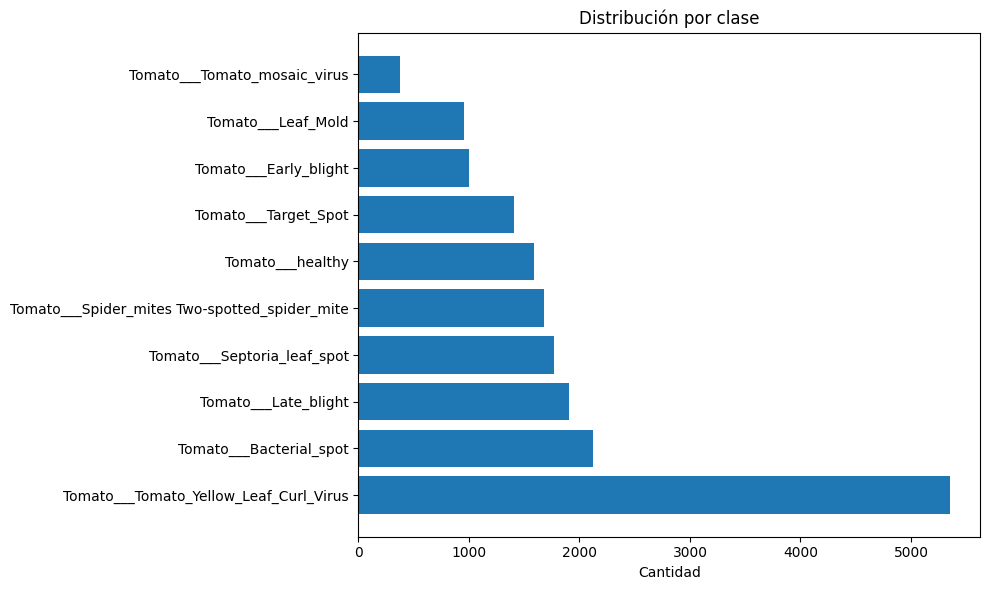


 ESTADÍSTICAS GLOBALES


,Ancho,Alto,Aspect,Brillo,Contraste,Entropia,Blur
count,18146.0,18146.0,18146.0,18146.000000,18146.000000,18146.000000,18146.000000
mean,256.0,256.0,1.0,115.607121,38.163846,6.998742,4095.634562
std,0.0,0.0,0.0,16.330085,10.695764,0.517583,4434.449148
min,256.0,256.0,1.0,8.246216,10.629742,1.352320,5.019577
25%,256.0,256.0,1.0,106.267632,29.963157,6.764452,716.729044
50%,256.0,256.0,1.0,115.971916,38.307126,7.076588,2740.308527
75%,256.0,256.0,1.0,124.544544,46.177556,7.352979,6145.844635
max,256.0,256.0,1.0,194.555527,80.729056,7.791131,27109.052995



 ESTADÍSTICAS POR CLASE


,Brillo,Contraste,Blur,Ancho,Alto
Clase,,,,,
Tomato___Bacterial_spot,104.92,33.41,1058.66,256.0,256.0
Tomato___Early_blight,110.58,46.31,3025.38,256.0,256.0
Tomato___Late_blight,113.61,39.63,2544.53,256.0,256.0
Tomato___Leaf_Mold,115.41,36.82,3162.19,256.0,256.0
Tomato___Septoria_leaf_spot,130.90,37.84,4766.69,256.0,256.0
Tomato___Spider_mites Two-spotted_spider_mite,119.27,44.56,6781.24,256.0,256.0
Tomato___Target_Spot,118.75,45.10,7209.69,256.0,256.0
Tomato___Tomato_Yellow_Leaf_Curl_Virus,114.20,34.71,1797.99,256.0,256.0
Tomato___Tomato_mosaic_virus,117.35,34.79,6142.23,256.0,256.0



 POSIBLES IMÁGENES PROBLEMÁTICAS

 Muy oscuras:


,Clase,Archivo,Brillo
4031,Tomato___Late_blight,ed974f5b-e999-46a9-9e22-da51da2766b6___GHLB_PS...,8.246216
4824,Tomato___Late_blight,17fcb016-4663-4f95-bc0b-b40392235015___GHLB_PS...,9.073990
3519,Tomato___Late_blight,1f2dc4ae-5264-443a-a103-67fafb37bc70___GHLB_PS...,9.820343
3420,Tomato___Late_blight,7b343a4c-5fbc-40f6-83da-ccae49ebd5fb___GHLB_PS...,10.304947
4121,Tomato___Late_blight,1159051e-1278-4b35-929c-e26b963d048f___GHLB_PS...,10.714142



 Muy claras:


,Clase,Archivo,Brillo
10320,Tomato___Target_Spot,4a144d06-1caf-4e45-84f5-c4b5196ed52f___Com.G_T...,194.555527
3094,Tomato___Early_blight,352ced01-4645-44e5-bc3e-1b7172deb883___RS_Erly...,187.847641
6327,Tomato___Septoria_leaf_spot,efbf830b-2408-403e-8fa0-86e22942b437___Matt.S_...,186.673767
11119,Tomato___Tomato_Yellow_Leaf_Curl_Virus,ab592870-b6d1-42a1-8169-e9c5b797c497___UF.GRC_...,185.820526
6992,Tomato___Septoria_leaf_spot,47540ec0-31bf-4ad5-84e9-601d0d0829e4___Matt.S_...,185.450790



 Muy borrosas:


,Clase,Archivo,Blur
14088,Tomato___Tomato_Yellow_Leaf_Curl_Virus,cd37cbce-e141-40a5-8af6-8fa6790c7ed3___UF.GRC_...,5.019577
12304,Tomato___Tomato_Yellow_Leaf_Curl_Virus,a5b5d284-5081-4340-9cfa-be58ed74aea3___UF.GRC_...,5.232528
14545,Tomato___Tomato_Yellow_Leaf_Curl_Virus,bdb46bf4-d226-4cd1-be9d-4ca36623fd5f___UF.GRC_...,7.885695
11502,Tomato___Tomato_Yellow_Leaf_Curl_Virus,8a92e970-1eb5-43f1-852e-2778ddde1503___UF.GRC_...,9.046097
12518,Tomato___Tomato_Yellow_Leaf_Curl_Virus,c6380761-954b-4a14-b686-05ce51868611___UF.GRC_...,9.248927


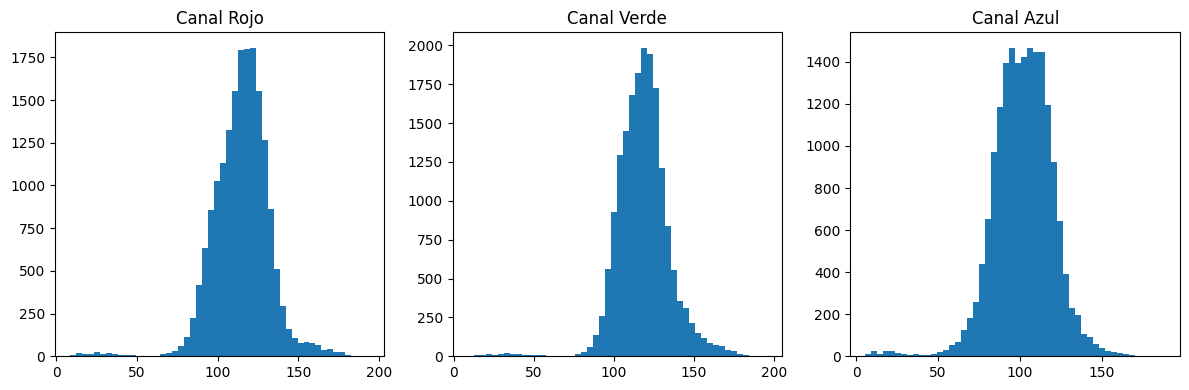


 IMÁGENES MÁS PEQUEÑAS


,Clase,Archivo,Ancho,Alto
18143,Tomato___healthy,724de01c-90cd-48e7-9360-749bb5b4713b___GH_HL L...,256,256
18142,Tomato___healthy,a424fe57-c3ff-400e-ac88-000ca1781300___RS_HL 9...,256,256
18141,Tomato___healthy,0cabff41-b00b-4692-98af-6b8b0aeba7aa___RS_HL 9...,256,256
18140,Tomato___healthy,ea0a8316-361e-4224-a700-5b86a8b93774___GH_HL L...,256,256
18139,Tomato___healthy,ec768816-02c1-4726-9374-b6d0ccec49d2___RS_HL 0...,256,256



 IMÁGENES MÁS GRANDES


,Clase,Archivo,Ancho,Alto
18145,Tomato___healthy,7c879fc2-09b8-47ab-af57-2508cc854861___GH_HL L...,256,256
0,Tomato___Bacterial_spot,c53b64d9-37ef-4269-b809-00e59c2a033f___GCREC_B...,256,256
18129,Tomato___healthy,0f9a114d-1df8-442c-90e7-d14d2f6efb23___RS_HL 9...,256,256
18128,Tomato___healthy,02d94768-da6d-4c1a-b8b3-fa2e5a2fcd4d___RS_HL 0...,256,256
18127,Tomato___healthy,19e31197-5f6d-4925-975c-884bd4a94bfe___RS_HL 0...,256,256



 DIAGNÓSTICO AUTOMÁTICO
Clases: 10
Imágenes: 18146
Ratio desbalance: 14.36
 Dataset desbalanceado → usar class_weight o data augmentation

 Recomendaciones técnicas:
- Redimensionar (224x224 o 256x256)
- Normalizar canales RGB
- Filtrar imágenes muy borrosas si afecta al modelo
- Data augmentation dirigido por clase
- Split estratificado train/val/test


In [ ]:
# ============================================
# BLOQUE 8
# EDA avanzado profesional para visión por computador
# Dataset: /content/TomatoDataset_merged
# ============================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

DATASET_DIR = "/content/TomatoDataset_merged"
VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp")

if not os.path.exists(DATASET_DIR):
    raise FileNotFoundError("No existe /content/TomatoDataset_merged. Ejecuta el BLOQUE 7.")

records = []
corrupted = []

# ---------------------------------------------------
# 1) Extracción avanzada de features por imagen
# ---------------------------------------------------
for class_name in sorted(os.listdir(DATASET_DIR)):
    class_path = os.path.join(DATASET_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    for fname in os.listdir(class_path):
        if fname.lower().endswith(VALID_EXT):
            path = os.path.join(class_path, fname)
            try:
                img = cv2.imread(path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                h, w = gray.shape
                aspect = w / h

                brightness = np.mean(gray)
                contrast = np.std(gray)
                entropy = -np.sum((p := np.histogram(gray, bins=256)[0]/np.prod(gray.shape)) * np.log2(p + 1e-9))

                blur = cv2.Laplacian(gray, cv2.CV_64F).var()

                r_mean = np.mean(img_rgb[:,:,0])
                g_mean = np.mean(img_rgb[:,:,1])
                b_mean = np.mean(img_rgb[:,:,2])

                records.append([class_name, fname, path, w, h, aspect,
                                brightness, contrast, entropy, blur,
                                r_mean, g_mean, b_mean])
            except:
                corrupted.append(path)

df = pd.DataFrame(records, columns=[
    "Clase","Archivo","Ruta","Ancho","Alto","Aspect",
    "Brillo","Contraste","Entropia","Blur",
    "R_mean","G_mean","B_mean"
])

# ---------------------------------------------------
# 2) Resumen general
# ---------------------------------------------------
print("\n RESUMEN GENERAL")
print("Total imágenes:", len(df))
print("Total clases:", df["Clase"].nunique())
print("Corruptas:", len(corrupted))

# ---------------------------------------------------
# 3) Distribución por clase
# ---------------------------------------------------
class_dist = df["Clase"].value_counts().to_frame("Cantidad")
class_dist["Porcentaje"] = (class_dist["Cantidad"] / len(df) * 100).round(2)
display(class_dist)

plt.figure(figsize=(10,6))
plt.barh(class_dist.index, class_dist["Cantidad"])
plt.title("Distribución por clase")
plt.xlabel("Cantidad")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 4) Estadísticas globales
# ---------------------------------------------------
print("\n ESTADÍSTICAS GLOBALES")
display(df[["Ancho","Alto","Aspect","Brillo","Contraste","Entropia","Blur"]].describe())

# ---------------------------------------------------
# 5) Estadísticas por clase
# ---------------------------------------------------
print("\n ESTADÍSTICAS POR CLASE")
class_stats = df.groupby("Clase").agg({
    "Brillo":"mean",
    "Contraste":"mean",
    "Blur":"mean",
    "Ancho":"mean",
    "Alto":"mean"
}).round(2)
display(class_stats)

# ---------------------------------------------------
# 6) Análisis de calidad visual
# ---------------------------------------------------
print("\n POSIBLES IMÁGENES PROBLEMÁTICAS")

print("\n Muy oscuras:")
display(df.sort_values("Brillo").head(5)[["Clase","Archivo","Brillo"]])

print("\n Muy claras:")
display(df.sort_values("Brillo", ascending=False).head(5)[["Clase","Archivo","Brillo"]])

print("\n Muy borrosas:")
display(df.sort_values("Blur").head(5)[["Clase","Archivo","Blur"]])

# ---------------------------------------------------
# 7) Análisis de color
# ---------------------------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.hist(df["R_mean"], bins=50); plt.title("Canal Rojo")
plt.subplot(1,3,2); plt.hist(df["G_mean"], bins=50); plt.title("Canal Verde")
plt.subplot(1,3,3); plt.hist(df["B_mean"], bins=50); plt.title("Canal Azul")
plt.tight_layout(); plt.show()

# ---------------------------------------------------
# 8) Outliers de tamaño
# ---------------------------------------------------
print("\n IMÁGENES MÁS PEQUEÑAS")
display(df.sort_values("Ancho").head(5)[["Clase","Archivo","Ancho","Alto"]])

print("\n IMÁGENES MÁS GRANDES")
display(df.sort_values("Ancho", ascending=False).head(5)[["Clase","Archivo","Ancho","Alto"]])

# ---------------------------------------------------
# 9) Diagnóstico automático
# ---------------------------------------------------
min_class = class_dist["Cantidad"].min()
max_class = class_dist["Cantidad"].max()
ratio = round(max_class / min_class, 2)

print("\n DIAGNÓSTICO AUTOMÁTICO")
print("Clases:", df['Clase'].nunique())
print("Imágenes:", len(df))
print("Ratio desbalance:", ratio)

if ratio > 3:
    print(" Dataset desbalanceado → usar class_weight o data augmentation")
else:
    print(" Dataset razonablemente balanceado")

print("\n Recomendaciones técnicas:")
print("- Redimensionar (224x224 o 256x256)")
print("- Normalizar canales RGB")
print("- Filtrar imágenes muy borrosas si afecta al modelo")
print("- Data augmentation dirigido por clase")
print("- Split estratificado train/val/test")


#  BLOQUE 9 — Limpieza automática del dataset + reporte + estadísticas + gráficos



## 1. Propósito del bloque
Este bloque implementa una etapa de **curación (data cleaning) para visión por computador**, que transforma un dataset consolidado pero “crudo” en un dataset **listo para entrenamiento**.

 **Entrada (fuente):**
- `/content/TomatoDataset_merged`

 **Salidas:**
- **Dataset listo** (solo imágenes aceptadas): `/content/TomatoDataset_ready`
- **Cuarentena** (imágenes sospechosas, no descartadas): `/content/TomatoDataset_quarantine`
- **Reporte CSV** (trazabilidad completa): `/content/TomatoDataset_cleaning_report.csv`

 Objetivos concretos:
- Detectar y descartar imágenes **corruptas** o **ilegibles**.
- Eliminar imágenes demasiado pequeñas (baja información útil).
- Identificar imágenes **borrosas** y moverlas a cuarentena (no necesariamente eliminarlas).
- Generar un **log detallado** por imagen (estado y motivo).
- Producir **estadísticas y visualizaciones** para justificar decisiones de limpieza.

---

## 2. Librerías utilizadas y rol técnico
Este bloque combina herramientas típicas en pipelines profesionales:

- **`os`**: recorrido del árbol de carpetas y manejo de rutas.
- **`shutil`**: copiado de archivos y eliminación/creación de directorios de salida.
- **`pandas`**: construcción del reporte tabular y agregaciones.
- **`PIL.Image`**: validación de apertura de imágenes (detección de corrupción).
- **`cv2 (OpenCV)`**: lectura alternativa + cálculo de borrosidad (blur).
- **`numpy`**: apoyo para cálculos y gráficas apiladas.
- **`matplotlib`**: gráficos para diagnóstico y control de calidad.

---

## 3. Parámetros y umbrales (criterios de limpieza)
Se definen **reglas explícitas** para decidir el destino de cada imagen:

### 3.1. Extensiones válidas
Solo se procesan archivos con extensiones típicas de imagen (JPG/PNG/BMP, etc.).  
Esto evita incluir metadatos o archivos no relevantes.

### 3.2. Tamaño mínimo permitido
Se establecen umbrales de ancho y alto mínimos:

- **`MIN_WIDTH`**
- **`MIN_HEIGHT`**

 Justificación:
Imágenes muy pequeñas suelen:
- perder detalles al redimensionar,
- contener poca señal relevante,
- introducir ruido y variabilidad no deseada.

### 3.3. Umbral de borrosidad (Blur)
Se define un umbral basado en una métrica estándar:

- **Varianza del Laplaciano**  
  - valor bajo → imagen más borrosa
  - valor alto → imagen más nítida

 Uso:
- Si la borrosidad está bajo el umbral, la imagen se envía a **cuarentena**.

 Esta decisión es metodológicamente sólida porque:
- no elimina automáticamente (evita pérdida excesiva),
- permite revisión manual,
- y ofrece control fino ajustando el umbral.

---

## 4. Verificación del prerequisito y limpieza de salidas previas
Antes de comenzar, el bloque:
- verifica que exista el dataset fuente (si no, se indica ejecutar BLOQUE 7),
- elimina versiones anteriores de:
  - `READY_DIR`
  - `QUAR_DIR`
- crea nuevamente las carpetas de salida limpias.

 Esto garantiza reproducibilidad: cada ejecución genera un resultado consistente.

---

## 5. Función de borrosidad: fundamento técnico
Se implementa una función para medir blur usando:

- **Laplaciano (detector de bordes)**
- **Varianza del Laplaciano** como cuantificador de nitidez

 Interpretación:
- Si una imagen tiene bordes fuertes y definidos → varianza alta → **nítida**.
- Si la imagen carece de bordes → varianza baja → **borrosa**.

Este criterio es ampliamente usado como heurística en preprocesamiento de imágenes.

---

## 6. Registro (logging) y contadores globales
Se prepara:
- una lista de registros (`log`) para guardar un resumen por imagen,
- contadores para:
  - total revisadas,
  - mantenidas,
  - enviadas a cuarentena,
  - descartadas.

 Esto permite medir el impacto real de la limpieza (qué porcentaje se pierde o se aparta).

---

## 7. Flujo principal: limpieza por clase e imagen (pipeline de decisión)
El bloque recorre cada clase (subcarpeta) y crea la misma estructura en las salidas:

- `/ready/<clase>`
- `/quarantine/<clase>`

Luego procesa cada imagen aplicando reglas secuenciales.

### 7.1. Paso A — Validación de apertura (detección de corrupción)
Se intenta abrir cada imagen con PIL para obtener dimensiones.  
Si falla:
- se marca como **descartada** (*discard*),
- se registra motivo (tipo de excepción),
- se continúa sin detener el proceso.

 Beneficio: robustez ante datasets imperfectos.

---

### 7.2. Paso B — Filtro por tamaño mínimo
Si la imagen existe pero es más pequeña que los umbrales:
- se descarta,
- se registra motivo “too_small”.

 Justificación ML:
Modelos CNN necesitan suficiente detalle; imágenes diminutas aportan poca señal y pueden deteriorar el aprendizaje.

---

### 7.3. Paso C — Cálculo de blur (OpenCV)
Se lee la imagen con OpenCV y se transforma a gris para medir borrosidad.  
Si OpenCV falla o el cálculo falla:
- se descarta,
- se registra motivo técnico.

 Esto evita introducir imágenes inconsistentes por fallos de decodificación.

---

### 7.4. Paso D — Cuarentena por borrosidad
Si el valor de blur es menor al umbral:
- la imagen se **copia a cuarentena**,
- se registra como “quarantine”,
- el motivo indica que estaba bajo el umbral.

 Enfoque profesional:
La cuarentena preserva datos potencialmente útiles, pero evita que contaminen el entrenamiento estándar.

---

### 7.5. Paso E — Mantener imagen válida
Si la imagen pasa todos los filtros:
- se copia a **READY**,
- se registra como “keep” con motivo “ok”.

---

## 8. Construcción y guardado del reporte (CSV)
Todos los registros se consolidan en un `DataFrame` con columnas típicas de auditoría:

- clase, archivo, ruta original
- estado (keep/quarantine/discard)
- motivo
- ancho, alto, blur

Luego se exporta a CSV.

 Esto aporta trazabilidad completa: se puede justificar por qué se descartó o aisló cada archivo.

---

## 9. Estadísticas generales del proceso
Se imprimen conteos y porcentajes por estado:

- % mantenidas
- % en cuarentena
- % descartadas

 Interpretación:
- descartes altos → dataset de baja calidad o umbrales estrictos
- cuarentena alta → umbral de blur posiblemente muy exigente o dataset con fotos movidas

---

## 10. Gráficos de diagnóstico (calidad global)

### 10.1. Distribución de estados
Se grafica cuántas imágenes quedaron en:
- keep
- quarantine
- discard

 Permite evaluar el impacto global del cleaning en segundos.

---

### 10.2. Histograma de Blur con umbral
Se grafica el histograma de blur y se marca el umbral con una línea vertical.

 Interpretación:
- si gran parte de la masa queda bajo el umbral → la mayoría quedará en cuarentena
- esto orienta el ajuste de `BLUR_THRESHOLD`

---

## 11. Análisis por clase: keep vs quarantine vs discard
Se crea una tabla pivot por clase con el conteo de cada estado.

Luego se grafica un **barras apiladas** para las principales clases.

 Esto permite detectar:
- clases con muchas imágenes borrosas (posible problema de captura por clase),
- clases con más descartes (posible corrupción o tamaños inconsistentes),
- desbalance real tras limpieza (no solo antes).

---

## 12. Estadísticas de tamaño (área) del dataset revisado
Se calcula el área como:

- **Área = Ancho × Alto**

Se muestran estadísticas descriptivas y un histograma del área.

 Utilidad:
- identificar outliers de tamaño,
- decidir estrategia de redimensionamiento,
- validar si el dataset requiere recortes o resizing uniforme.

---

## 13. Recomendaciones automáticas para modelado
El bloque calcula un **ratio de desbalance** usando el total por clase.

- Si `max/min > 3` → se considera desbalanceado y recomienda:
  - `class_weight`
  - data augmentation dirigido

Además, entrega recomendaciones típicas:
- resize estándar (224 o 256)
- revisar `BLUR_THRESHOLD` si cuarentena supera un umbral significativo.

 Este cierre conecta limpieza → decisiones de entrenamiento (puente EDA → modelado).

---

##  Resultado esperado del bloque
Al finalizar, se obtiene un pipeline de limpieza reproducible que:

1. Produce un dataset listo para entrenamiento: **`TomatoDataset_ready`**
2. Separa imágenes dudosas en cuarentena: **`TomatoDataset_quarantine`**
3. Genera un reporte auditable: **`TomatoDataset_cleaning_report.csv`**
4. Entrega estadísticas y gráficos para justificar decisiones
5. Recomienda estrategias de entrenamiento según el diagnóstico

Este bloque corresponde a una etapa profesional de **Data Quality Assurance** para proyectos de **Deep Learning en visión por computador**.


 LIMPIEZA COMPLETADA
 - Total imágenes revisadas: 18146
 - Mantener (READY): 17543  (96.68%)
 - Cuarentena: 603 (3.32%)
 - Descartadas: 0 (0.00%)

 Dataset listo: /content/TomatoDataset_ready
 Cuarentena: /content/TomatoDataset_quarantine
 Reporte: /content/TomatoDataset_cleaning_report.csv

 Vista rápida del reporte (primeras 10 filas):


,Clase,Archivo,Ruta_origen,Estado,Motivo,Ancho,Alto,Blur
0,Tomato___Bacterial_spot,00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_B...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,672.112518
1,Tomato___Bacterial_spot,0045ba29-ed1b-43b4-afde-719cc7adefdb___GCREC_B...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,1545.125317
2,Tomato___Bacterial_spot,00639d29-2d1a-4fcf-9bd3-a2b3109c74c4___UF.GRC_...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,785.756565
3,Tomato___Bacterial_spot,00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_B...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,1940.613708
4,Tomato___Bacterial_spot,00a7c269-3476-4d25-b744-44d6353cd921___GCREC_B...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,1306.964077
5,Tomato___Bacterial_spot,00b7e89a-e129-4576-b51f-48923888bff9___GCREC_B...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,1599.762820
6,Tomato___Bacterial_spot,01375198-62af-4c40-bddf-f3c11107200b___GCREC_B...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,1254.932037
7,Tomato___Bacterial_spot,014b58ae-091b-408a-ab4a-5a780cd1c3f3___GCREC_B...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,319.953421
8,Tomato___Bacterial_spot,01a3cf3f-94c1-44d5-8972-8c509d62558e___GCREC_B...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,1210.490609
9,Tomato___Bacterial_spot,01a46cb5-d354-4f59-868e-e56186701541___GCREC_B...,/content/TomatoDataset_merged/Tomato___Bacteri...,keep,ok,256,256,970.336764


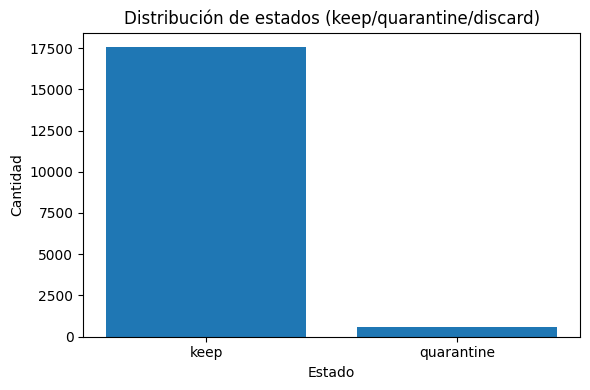

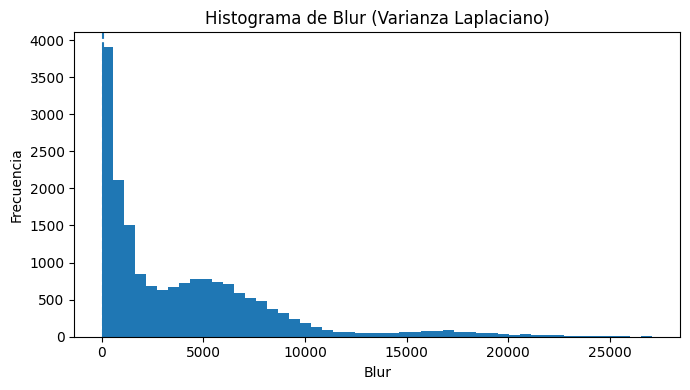


 Tabla por clase (keep/quarantine/discard):


Estado,keep,quarantine,total
Clase,,,
Tomato___Tomato_Yellow_Leaf_Curl_Virus,4761,596,5357
Tomato___Bacterial_spot,2126,1,2127
Tomato___Late_blight,1897,4,1901
Tomato___Septoria_leaf_spot,1771,0,1771
Tomato___Spider_mites Two-spotted_spider_mite,1676,0,1676
Tomato___healthy,1585,0,1585
Tomato___Target_Spot,1404,0,1404
Tomato___Early_blight,998,2,1000
Tomato___Leaf_Mold,952,0,952


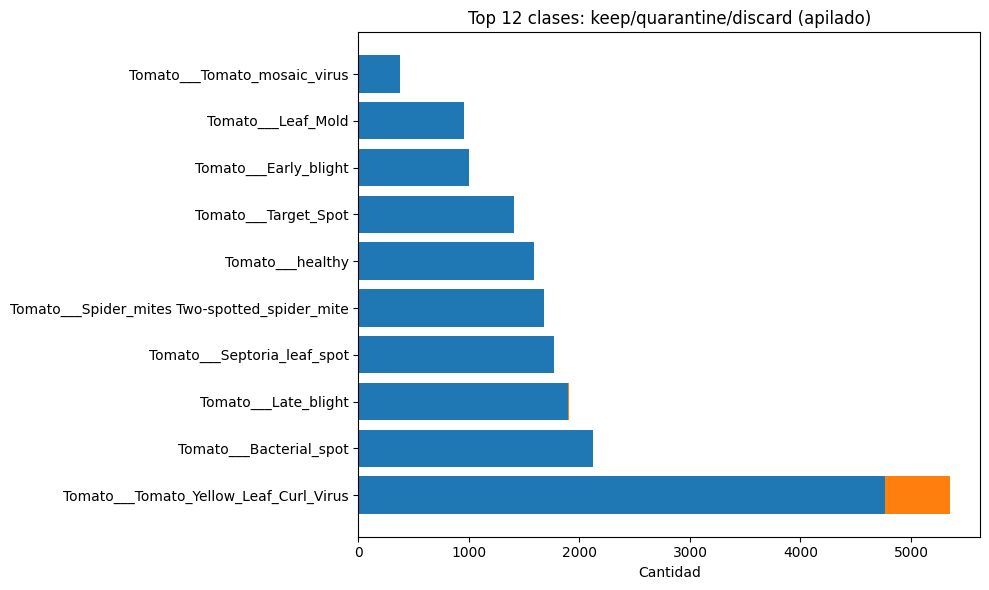


 Estadísticas de tamaños (global):


,Ancho,Alto,Area
count,18146.0,18146.0,18146.0
mean,256.0,256.0,65536.0
std,0.0,0.0,0.0
min,256.0,256.0,65536.0
25%,256.0,256.0,65536.0
50%,256.0,256.0,65536.0
75%,256.0,256.0,65536.0
max,256.0,256.0,65536.0


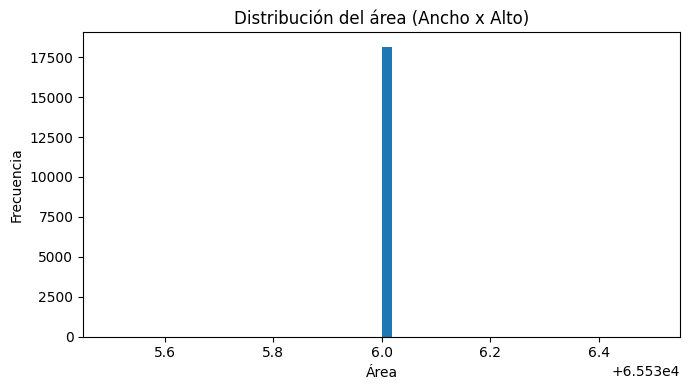


 RECOMENDACIONES AUTOMÁTICAS
 - Clases detectadas: 10
 - Ratio de desbalance (max/min): 14.36
  Dataset desbalanceado → usar class_weight o data augmentation.
 - Sugerencia de resize típico: 224x224 (transfer learning) o 256x256.
 - Si cuarentena >10%: revisa el umbral BLUR_THRESHOLD.


In [ ]:
# ============================================
# BLOQUE 9
# Limpieza automática + estadísticas + gráficos
# Fuente:  /content/TomatoDataset_merged
# Salida:  /content/TomatoDataset_ready
# Quarantine: /content/TomatoDataset_quarantine
# Reporte: /content/TomatoDataset_cleaning_report.csv
# ============================================

import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

SRC_DIR = "/content/TomatoDataset_merged"
READY_DIR = "/content/TomatoDataset_ready"
QUAR_DIR = "/content/TomatoDataset_quarantine"
REPORT_CSV = "/content/TomatoDataset_cleaning_report.csv"

VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp")

# Umbrales (ajustables)
MIN_WIDTH = 64
MIN_HEIGHT = 64
BLUR_THRESHOLD = 60.0  # menor => más borrosa (ajusta si quieres ser más estricto)

if not os.path.exists(SRC_DIR):
    raise FileNotFoundError(f"No existe {SRC_DIR}. Ejecuta el BLOQUE 7.")

# Limpiar salidas anteriores
shutil.rmtree(READY_DIR, ignore_errors=True)
shutil.rmtree(QUAR_DIR, ignore_errors=True)
os.makedirs(READY_DIR, exist_ok=True)
os.makedirs(QUAR_DIR, exist_ok=True)

def variance_of_laplacian(image_gray):
    return cv2.Laplacian(image_gray, cv2.CV_64F).var()

log = []
total_files = kept = quarantined = discarded = 0

# --------------------------------------------
# 1) Limpieza y logging
# --------------------------------------------
for class_name in sorted(os.listdir(SRC_DIR)):
    class_path = os.path.join(SRC_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    ready_class_dir = os.path.join(READY_DIR, class_name)
    quar_class_dir = os.path.join(QUAR_DIR, class_name)
    os.makedirs(ready_class_dir, exist_ok=True)
    os.makedirs(quar_class_dir, exist_ok=True)

    for fname in sorted(os.listdir(class_path)):
        if not fname.lower().endswith(VALID_EXT):
            continue

        total_files += 1
        src_file = os.path.join(class_path, fname)

        status = None
        reason = None
        w = h = None
        blur = None

        # A) Verificar que abre con PIL
        try:
            with Image.open(src_file) as img:
                w, h = img.size
        except Exception as e:
            status = "discard"
            reason = f"corrupt_or_unreadable:{type(e).__name__}"
            discarded += 1
            log.append([class_name, fname, src_file, status, reason, w, h, blur])
            continue

        # B) Tamaño mínimo
        if w < MIN_WIDTH or h < MIN_HEIGHT:
            status = "discard"
            reason = f"too_small<{MIN_WIDTH}x{MIN_HEIGHT}"
            discarded += 1
            log.append([class_name, fname, src_file, status, reason, w, h, blur])
            continue

        # C) Blur (OpenCV)
        try:
            img_cv = cv2.imread(src_file)
            if img_cv is None:
                status = "discard"
                reason = "cv2_imread_failed"
                discarded += 1
                log.append([class_name, fname, src_file, status, reason, w, h, blur])
                continue

            gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
            blur = float(variance_of_laplacian(gray))
        except Exception as e:
            status = "discard"
            reason = f"blur_calc_failed:{type(e).__name__}"
            discarded += 1
            log.append([class_name, fname, src_file, status, reason, w, h, blur])
            continue

        # D) Cuarentena por borrosidad
        if blur < BLUR_THRESHOLD:
            shutil.copy2(src_file, os.path.join(quar_class_dir, fname))
            status = "quarantine"
            reason = f"blurry<{BLUR_THRESHOLD}"
            quarantined += 1
            log.append([class_name, fname, src_file, status, reason, w, h, blur])
            continue

        # E) Mantener
        shutil.copy2(src_file, os.path.join(ready_class_dir, fname))
        status = "keep"
        reason = "ok"
        kept += 1
        log.append([class_name, fname, src_file, status, reason, w, h, blur])

# --------------------------------------------
# 2) Guardar reporte
# --------------------------------------------
df_log = pd.DataFrame(log, columns=[
    "Clase","Archivo","Ruta_origen","Estado","Motivo","Ancho","Alto","Blur"
])
df_log.to_csv(REPORT_CSV, index=False)

# --------------------------------------------
# 3) Estadísticas generales
# --------------------------------------------
print(" LIMPIEZA COMPLETADA")
print(f" - Total imágenes revisadas: {total_files}")
print(f" - Mantener (READY): {kept}  ({kept/total_files*100:.2f}%)")
print(f" - Cuarentena: {quarantined} ({quarantined/total_files*100:.2f}%)")
print(f" - Descartadas: {discarded} ({discarded/total_files*100:.2f}%)")
print("\n Dataset listo:", READY_DIR)
print(" Cuarentena:", QUAR_DIR)
print(" Reporte:", REPORT_CSV)

print("\n Vista rápida del reporte (primeras 10 filas):")
display(df_log.head(10))

# --------------------------------------------
# 4) Gráfico: distribución de estados
# --------------------------------------------
state_counts = df_log["Estado"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(state_counts.index, state_counts.values)
plt.title("Distribución de estados (keep/quarantine/discard)")
plt.xlabel("Estado")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

# --------------------------------------------
# 5) Gráfico: histograma de Blur (solo donde existe)
# --------------------------------------------
blur_vals = df_log["Blur"].dropna()

plt.figure(figsize=(7,4))
plt.hist(blur_vals, bins=50)
plt.title("Histograma de Blur (Varianza Laplaciano)")
plt.xlabel("Blur")
plt.ylabel("Frecuencia")
plt.axvline(BLUR_THRESHOLD, linestyle="--")
plt.tight_layout()
plt.show()

# --------------------------------------------
# 6) Distribución por clase (keep) vs (quarantine) vs (discard)
# --------------------------------------------
pivot = df_log.pivot_table(index="Clase", columns="Estado", values="Archivo", aggfunc="count", fill_value=0)
pivot["total"] = pivot.sum(axis=1)
pivot = pivot.sort_values("total", ascending=False)

print("\n Tabla por clase (keep/quarantine/discard):")
display(pivot.head(15))

plt.figure(figsize=(10,6))
topk = pivot.head(12)
bottom = np.zeros(len(topk))

for col in [c for c in ["keep","quarantine","discard"] if c in topk.columns]:
    plt.barh(topk.index, topk[col], left=bottom)
    bottom += topk[col].values

plt.title("Top 12 clases: keep/quarantine/discard (apilado)")
plt.xlabel("Cantidad")
plt.tight_layout()
plt.show()

# --------------------------------------------
# 7) Estadísticas de tamaño (READY y cuarentena)
# --------------------------------------------
sizes = df_log.dropna(subset=["Ancho","Alto"]).copy()
sizes["Area"] = sizes["Ancho"] * sizes["Alto"]

print("\n Estadísticas de tamaños (global):")
display(sizes[["Ancho","Alto","Area"]].describe())

plt.figure(figsize=(7,4))
plt.hist(sizes["Area"], bins=50)
plt.title("Distribución del área (Ancho x Alto)")
plt.xlabel("Área")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# --------------------------------------------
# 8) Recomendaciones automáticas
# --------------------------------------------
print("\n RECOMENDACIONES AUTOMÁTICAS")
min_class = pivot["total"].min() if len(pivot) else 0
max_class = pivot["total"].max() if len(pivot) else 0
ratio = round(max_class / min_class, 2) if min_class > 0 else None

print(f" - Clases detectadas: {pivot.shape[0]}")
print(f" - Ratio de desbalance (max/min): {ratio}")

if ratio and ratio > 3:
    print("  Dataset desbalanceado → usar class_weight o data augmentation.")
else:
    print("  Dataset razonablemente balanceado.")

print(" - Sugerencia de resize típico: 224x224 (transfer learning) o 256x256.")
print(" - Si cuarentena >10%: revisa el umbral BLUR_THRESHOLD.")



# BLOQUE 10 — Split estratificado Train/Val/Test para un dataset de imágenes por carpetas


## 1. Propósito del bloque
Este bloque implementa una etapa fundamental del pipeline de *Machine Learning / Deep Learning*: la **partición del dataset** en tres subconjuntos **mutuamente excluyentes**:

- **Train (entrenamiento)**: para ajustar los parámetros del modelo.
- **Val (validación)**: para seleccionar hiperparámetros y monitorear sobreajuste.
- **Test (prueba)**: para estimar desempeño final (generalización) sin sesgo.

 **Entrada:**
- `/content/TomatoDataset_ready` (dataset ya limpio, resultado del BLOQUE 9)

 **Salida:**
- `/content/TomatoDataset_split/{train,val,test}/<clase>/*`

 **Reporte:**
- `/content/TomatoDataset_split_report.csv` (trazabilidad por clase)

---

## 2. Fundamento teórico: ¿por qué separar Train/Val/Test?
En clasificación de imágenes, si se entrena y se evalúa con las mismas imágenes, se incurre en **sobreestimación del rendimiento** (el modelo memoriza). Para evitarlo:

- **Train**: aprende patrones (optimización).
- **Val**: evalúa durante el entrenamiento y guía decisiones (regularización, early stopping, tuning).
- **Test**: se reserva como evaluación final objetiva.

 Además, al tratarse de un problema multiclase, se requiere que la distribución de clases se mantenga similar en cada subconjunto, lo que se logra mediante un **split estratificado por clase**.

---

## 3. Librerías utilizadas y rol práctico
Se usan herramientas estándar para manipulación de archivos y reportes:

- **`os`**: listar clases, construir rutas, verificar directorios.
- **`shutil`**: copiar archivos preservando metadatos (copia segura).
- **`random`**: mezclar (shuffle) archivos antes de asignarlos.
- **`pandas`**: generar y exportar el reporte tabular por clase.

---

## 4. Parámetros del split y reproducibilidad

### 4.1. Definición de proporciones
Se definen proporciones para cada subconjunto:

- `TRAIN_RATIO = 0.70`
- `VAL_RATIO   = 0.15`
- `TEST_RATIO  = 0.15`

 Relevancia:
- 70/15/15 es una configuración común y razonable cuando se tiene un dataset de tamaño medio.
- Mantiene suficiente data para entrenar y suficiente data para validar y probar.

### 4.2. Semilla aleatoria (reproducibilidad)
Se fija una semilla (`SEED`) y se inicializa el generador aleatorio.

 Esto garantiza que:
- el orden de barajado sea repetible,
- y el split sea idéntico si se ejecuta nuevamente bajo el mismo dataset.

---

## 5. Validaciones previas (control de errores)
Antes de dividir el dataset, se realizan dos verificaciones críticas:

1. **Existencia del dataset de entrada**  
   - Si no existe, se detiene indicando que debe ejecutarse el BLOQUE 9.

2. **Consistencia matemática de proporciones**  
   - Se valida que `train + val + test = 1.0` (con tolerancia numérica).

 Estas validaciones evitan:
- errores de ejecución,
- splits inconsistentes,
- y resultados no reproducibles.

---

## 6. Preparación del directorio de salida
El bloque:
- elimina cualquier versión previa del directorio `OUT_DIR`,
- lo recrea vacío,
- y crea subcarpetas para cada split:

- `train/`
- `val/`
- `test/`

 Esta estructura es compatible directamente con:
- `tf.keras.utils.image_dataset_from_directory`,
- `ImageDataGenerator.flow_from_directory`,
- y pipelines `tf.data`.

---

## 7. Split estratificado por clase (núcleo del procedimiento)

### 7.1. Identificación de clases
Se identifican todas las clases como subcarpetas dentro de `SRC_DIR`.
Esto asume el formato estándar de dataset por carpetas:
- una carpeta por clase, con imágenes en su interior.

---

### 7.2. Proceso por clase (estratificación)
Para cada clase:

1. Se listan las imágenes válidas (por extensión).
2. Se ordenan y se mezclan aleatoriamente (shuffle).
3. Se calcula el tamaño total `n`.
4. Se calcula cuántas irán a:
   - train = `int(n * TRAIN_RATIO)`
   - val   = `int(n * VAL_RATIO)`
   - test  = `n - train - val`

 Punto técnico importante:
- La fórmula para test garantiza que **la suma sea exacta**, evitando pérdidas por truncamiento (redondeos).

---

### 7.3. Asignación a cada split
Luego, se particiona la lista barajada en tres segmentos contiguos:
- primeras `n_train` → train
- siguientes `n_val` → val
- restantes → test

 Esto implementa un split estratificado porque se hace **independientemente por clase**, preservando la proporción de cada clase en cada subset.

---

### 7.4. Copia de archivos en estructura destino
Para cada split, se crea la carpeta destino de la clase:

- `train/<clase>/`
- `val/<clase>/`
- `test/<clase>/`

Luego se copian físicamente los archivos a su destino correspondiente.

 Justificación práctica:
- Copiar (en lugar de mover) conserva el dataset original `ready` como respaldo.
- Evita pérdida accidental de datos y facilita auditoría.

---

## 8. Construcción del reporte por clase
Para cada clase se registra:
- total de imágenes
- cuántas fueron a train, val y test

Luego se crea un `DataFrame` y se calculan porcentajes:

- `Train_%`
- `Val_%`
- `Test_%`

Finalmente:
- se guarda el reporte en CSV (`REPORT_CSV`) para trazabilidad.

 Este reporte es esencial para documentación académica:
- evidencia que se respetó la estratificación,
- permite detectar clases con muy pocos ejemplos (problema típico).

---

## 9. Resúmenes finales y verificación global
El bloque imprime:

- confirmación del split completado,
- ruta del dataset dividido,
- ruta del reporte,
- una vista de las primeras clases,
- totales globales (sumas de train/val/test),
- y un ejemplo de la estructura creada.

 Esto funciona como validación rápida:
- la suma total debe coincidir con el número total de imágenes,
- y las carpetas deben existir para que el entrenamiento sea directo.

---

##  Resultado esperado del bloque
Al terminar, el pipeline deja listo un dataset totalmente compatible con entrenamiento en Keras/TensorFlow:

- `/content/TomatoDataset_split/train/<clase>/*`
- `/content/TomatoDataset_split/val/<clase>/*`
- `/content/TomatoDataset_split/test/<clase>/*`

Y genera un reporte auditable:
- `/content/TomatoDataset_split_report.csv`

---

##  Relevancia para el rendimiento y la evaluación del modelo
Este bloque es crítico porque:

- evita **fuga de información** entre train y test,
- permite monitorear **sobreajuste** usando validación,
- y asegura una evaluación final **justa y reproducible** en test.

En un contexto académico/profesional, esta etapa fundamenta la validez de cualquier métrica reportada posteriormente (accuracy, F1, recall, etc.).


In [ ]:
# ============================================
# BLOQUE 10
# Split estratificado Train/Val/Test
# Input : /content/TomatoDataset_ready
# Output: /content/TomatoDataset_split/{train,val,test}/<clase>/*
# Reporte: /content/TomatoDataset_split_report.csv
# ============================================

import os
import shutil
import random
import pandas as pd

SRC_DIR = "/content/TomatoDataset_ready"
OUT_DIR = "/content/TomatoDataset_split"
REPORT_CSV = "/content/TomatoDataset_split_report.csv"

VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp")

# Proporciones (deben sumar 1.0)
TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

SEED = 42
random.seed(SEED)

# Validaciones básicas
if not os.path.exists(SRC_DIR):
    raise FileNotFoundError(f"No existe {SRC_DIR}. Ejecuta el BLOQUE 9 (MEJORADO) primero.")

if abs((TRAIN_RATIO + VAL_RATIO + TEST_RATIO) - 1.0) > 1e-9:
    raise ValueError("TRAIN_RATIO + VAL_RATIO + TEST_RATIO debe sumar 1.0")

# Limpiar salida anterior
shutil.rmtree(OUT_DIR, ignore_errors=True)
os.makedirs(OUT_DIR, exist_ok=True)

for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUT_DIR, split), exist_ok=True)

# --------------------------------------------
# 1) Split por clase (estratificado)
# --------------------------------------------
report_rows = []

classes = sorted([d for d in os.listdir(SRC_DIR) if os.path.isdir(os.path.join(SRC_DIR, d))])

for class_name in classes:
    class_path = os.path.join(SRC_DIR, class_name)
    files = [f for f in os.listdir(class_path) if f.lower().endswith(VALID_EXT)]
    files.sort()
    random.shuffle(files)

    n = len(files)
    n_train = int(n * TRAIN_RATIO)
    n_val = int(n * VAL_RATIO)
    n_test = n - n_train - n_val  # asegura suma exacta

    train_files = files[:n_train]
    val_files   = files[n_train:n_train + n_val]
    test_files  = files[n_train + n_val:]

    # Crear carpetas destino de esta clase
    train_dst = os.path.join(OUT_DIR, "train", class_name)
    val_dst   = os.path.join(OUT_DIR, "val", class_name)
    test_dst  = os.path.join(OUT_DIR, "test", class_name)

    os.makedirs(train_dst, exist_ok=True)
    os.makedirs(val_dst, exist_ok=True)
    os.makedirs(test_dst, exist_ok=True)

    # Copiar archivos
    for f in train_files:
        shutil.copy2(os.path.join(class_path, f), os.path.join(train_dst, f))
    for f in val_files:
        shutil.copy2(os.path.join(class_path, f), os.path.join(val_dst, f))
    for f in test_files:
        shutil.copy2(os.path.join(class_path, f), os.path.join(test_dst, f))

    report_rows.append([class_name, n, len(train_files), len(val_files), len(test_files)])

# --------------------------------------------
# 2) Reporte por clase
# --------------------------------------------
df_report = pd.DataFrame(report_rows, columns=["Clase", "Total", "Train", "Val", "Test"])
df_report["Train_%"] = (df_report["Train"] / df_report["Total"] * 100).round(2)
df_report["Val_%"]   = (df_report["Val"]   / df_report["Total"] * 100).round(2)
df_report["Test_%"]  = (df_report["Test"]  / df_report["Total"] * 100).round(2)

df_report.to_csv(REPORT_CSV, index=False)

print(" SPLIT COMPLETADO")
print(f" Dataset split en: {OUT_DIR}")
print(f" Reporte guardado en: {REPORT_CSV}\n")

print(" Resumen (primeras 15 clases):")
display(df_report.head(15))

print("\n Totales globales:")
print(" - Total imágenes:", int(df_report["Total"].sum()))
print(" - Train:", int(df_report["Train"].sum()))
print(" - Val:", int(df_report["Val"].sum()))
print(" - Test:", int(df_report["Test"].sum()))

print("\n Estructura creada (ejemplo):")
print(" - /content/TomatoDataset_split/train/<clase>/")
print(" - /content/TomatoDataset_split/val/<clase>/")
print(" - /content/TomatoDataset_split/test/<clase>/")


 SPLIT COMPLETADO
 Dataset split en: /content/TomatoDataset_split
 Reporte guardado en: /content/TomatoDataset_split_report.csv

 Resumen (primeras 15 clases):


,Clase,Total,Train,Val,Test,Train_%,Val_%,Test_%
0,TomatoDataset_ready,0,0,0,0,NaN,NaN,NaN
1,Tomato___Bacterial_spot,2126,1488,318,320,69.99,14.96,15.05
2,Tomato___Early_blight,998,698,149,151,69.94,14.93,15.13
3,Tomato___Late_blight,1897,1327,284,286,69.95,14.97,15.08
4,Tomato___Leaf_Mold,952,666,142,144,69.96,14.92,15.13
5,Tomato___Septoria_leaf_spot,1771,1239,265,267,69.96,14.96,15.08
6,Tomato___Spider_mites Two-spotted_spider_mite,1676,1173,251,252,69.99,14.98,15.04
7,Tomato___Target_Spot,1404,982,210,212,69.94,14.96,15.10
8,Tomato___Tomato_Yellow_Leaf_Curl_Virus,4761,3332,714,715,69.99,15.00,15.02
9,Tomato___Tomato_mosaic_virus,373,261,55,57,69.97,14.75,15.28



 Totales globales:
 - Total imágenes: 17543
 - Train: 12275
 - Val: 2625
 - Test: 2643

 Estructura creada (ejemplo):
 - /content/TomatoDataset_split/train/<clase>/
 - /content/TomatoDataset_split/val/<clase>/
 - /content/TomatoDataset_split/test/<clase>/


# Comprimir el directorio TomatoDataset_ready en Google Colab

#  Bloque 11 — Compresión del dataset en formato ZIP (para descarga o respaldo)

## 1. Propósito del bloque
Este bloque ejecuta una acción típica de **ingeniería de datos en Google Colab**: comprimir el directorio del dataset **`TomatoDataset_ready`** en un archivo **`.zip`**.

 **Objetivo principal:**
- Generar un paquete portable y único del dataset **ya limpiado y listo para entrenamiento**, facilitando:
  - descarga a tu computador,
  - respaldo (backup),
  - transferencia a otro entorno,
  - reutilización en otros notebooks o proyectos.

---

## 2. Qué ocurre técnicamente al ejecutar el comando
Se utiliza el comando de sistema **`zip`** desde la celda (prefijo `!`), lo que significa que **no se ejecuta como Python**, sino como un comando del sistema operativo Linux que corre en el entorno de Colab.

El comando realiza:

1. **Creación del archivo comprimido**
   - Se crea un archivo llamado **`TomatoDataset_ready.zip`**.

2. **Compresión recursiva del directorio**
   - Se comprime la carpeta **`TomatoDataset_ready/`** incluyendo:
     - todas sus subcarpetas (clases),
     - y todos los archivos de imagen dentro de ellas.

3. **Preservación de estructura**
   - La estructura por clases se mantiene intacta dentro del ZIP, lo cual es clave porque el entrenamiento posterior requiere el formato:
     - `TomatoDataset_ready/<clase>/*.jpg|png|...`

---

## 3. Por qué esto es útil en un pipeline de Machine Learning
En proyectos de visión por computador, el dataset pasa por fases:
- **dataset crudo** → (limpieza) → **dataset listo** → (split) → entrenamiento

Este bloque aparece justo después de la limpieza (dataset “ready”) y permite:

-  “Congelar” una versión estable del dataset
-  Compartirlo o moverlo sin recalcular limpieza
-  Reproducir experimentos con exactamente los mismos datos
-  Reducir fricción operativa al migrar entre entornos

---

## 4. Consideraciones prácticas importantes
- Si el dataset es grande, el archivo ZIP puede:
  - tardar en generarse,
  - y ocupar bastante espacio en el almacenamiento temporal de Colab.
- El proceso es determinista respecto a los archivos contenidos, pero el tamaño final dependerá de:
  - la cantidad de imágenes,
  - el formato (JPG suele comprimir mejor que PNG),
  - y la resolución de cada imagen.

---

##  Resultado esperado
Al finalizar, tendrás disponible en el directorio actual de Colab un archivo:

- **`TomatoDataset_ready.zip`**

que contiene el dataset listo para ser descargado o respaldado.


In [ ]:
!zip -r TomatoDataset_ready.zip TomatoDataset_ready


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  adding: TomatoDataset_ready/Tomato___Tomato_Yellow_Leaf_Curl_Virus/ae8a45c1-aa76-4b64-ae85-ae56f852e2c5___YLCV_NREC 2628.JPG (deflated 1%)
  adding: TomatoDataset_ready/Tomato___Tomato_Yellow_Leaf_Curl_Virus/5082c000-323f-4002-86e1-d446e94be8f7___YLCV_GCREC 2670.JPG (deflated 2%)
  adding: TomatoDataset_ready/Tomato___Tomato_Yellow_Leaf_Curl_Virus/f8beafc6-060e-4310-a89a-d1e54fdb66bb___UF.GRC_YLCV_Lab 01420.JPG (deflated 2%)
  adding: TomatoDataset_ready/Tomato___Tomato_Yellow_Leaf_Curl_Virus/207fc955-4430-4829-b860-d3044662115a___UF.GRC_YLCV_Lab 01930.JPG (deflated 1%)
  adding: TomatoDataset_ready/Tomato___Tomato_Yellow_Leaf_Curl_Virus/fc8d8c51-99a2-4dc2-8b2c-c304f793fb86___YLCV_NREC 2829.JPG (deflated 1%)
  adding: TomatoDataset_ready/Tomato___Tomato_Yellow_Leaf_Curl_Virus/78231f4b-f77d-4ef8-84d0-b1a2f2fbfdcf___UF.GRC_YLCV_Lab 09447.JPG (deflated 2%)
  adding: TomatoDataset_ready/Tomato___Tomato_Yellow_Leaf_Curl_Vi

In [ ]:
# ============================================
# BLOQUE 2
# Crear un árbol SOLO con subcarpetas (sin archivos)
# ============================================

import os

ROOT_DIR = "/content/TomatoDataset_ready"   # cambia esto si tu carpeta tiene otro nombre

if not os.path.exists(ROOT_DIR):
    raise FileNotFoundError(f"No existe la ruta: {ROOT_DIR}. ¿Ejecutaste el BLOQUE 1?")

def print_dir_tree(path, max_depth=10):
    """
    Imprime un árbol de SOLO directorios.
    - max_depth: profundidad máxima del árbol
    """
    path = os.path.abspath(path)
    base_depth = path.rstrip(os.sep).count(os.sep)

    print(f" Árbol de directorios: {path}\n")

    for root, dirs, _ in os.walk(path):
        depth = root.count(os.sep) - base_depth
        if depth > max_depth:
            dirs[:] = []
            continue

        indent = "│   " * depth
        folder_name = os.path.basename(root) if root != path else os.path.basename(path)
        print(f"{indent}├── {folder_name}/")

        # Orden alfabético
        dirs.sort()

print_dir_tree(ROOT_DIR, max_depth=10)


 Árbol de directorios: /content/TomatoDataset_ready

├── TomatoDataset_ready/
│   ├── TomatoDataset_ready/
│   ├── Tomato___Bacterial_spot/
│   ├── Tomato___Early_blight/
│   ├── Tomato___Late_blight/
│   ├── Tomato___Leaf_Mold/
│   ├── Tomato___Septoria_leaf_spot/
│   ├── Tomato___Spider_mites Two-spotted_spider_mite/
│   ├── Tomato___Target_Spot/
│   ├── Tomato___Tomato_Yellow_Leaf_Curl_Virus/
│   ├── Tomato___Tomato_mosaic_virus/
│   ├── Tomato___healthy/
